In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Circle
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize, ListedColormap
import matplotlib.colorbar as colorbar
import matplotlib.gridspec as gridspec
from matplotlib.widgets import Slider
import matplotlib.animation as animation
import matplotlib as mat
import os
import os.path as op
from scipy.stats import gaussian_kde
from matplotlib import font_manager as fm
import seaborn as sea
import statsmodels.api as sm
from scipy.interpolate import make_interp_spline
from scipy.stats import rayleigh, norm
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.signal import savgol_filter
from peregrin.scripts import PlotParams, FilesAndFolders

In [247]:
# input file path:
input_file1 = r"C:\Users\modri\Desktop\Lab\runs from the same experiment\C2-position_spots1.csv"
input_file2 = r"C:\Users\modri\Desktop\Lab\runs from the same experiment\C2-position_spots2.csv"
input_file3 = r"C:\Users\modri\Desktop\Lab\runs from the same experiment\C2-position_spots3.csv"
# input_file2 = pd.DataFrame().empty
# input_file3 = pd.DataFrame().empty

In [248]:
input_files = [input_file1, input_file2, input_file3]
# input_files = [input_file1]

In [249]:
# ===========================================================================================================================================================================================================================================================================	
# Optics parameters

# Definition of micron length per pixel
microns_per_pixel = 0.7381885238402274 # for 10x lens

# Define the desired dimensions in microns
x_min, x_max = 0, (1600 * microns_per_pixel)
y_min, y_max = 0, (1200 * microns_per_pixel)
x_axe_remainder = x_max-1150
x_add = 50 - x_axe_remainder
y_ax_remainder = y_max-850
x_substract = (x_max - y_max) + (y_ax_remainder - 50)

# Calculate the aspect ratio
aspect_ratio = x_max / y_max



# ===========================================================================================================================================================================================================================================================================
# Globally used callables

# plot specs
title_size = 16
title_size2 = 12
label_size = 11
figtext_size = 9
compass_annotations_size = 15
figtext_color = 'grey'

# Color maps
cmap_cells = mcolors.LinearSegmentedColormap.from_list("", ["#9b598910", "#9b181eff"])
cmap_frames = plt.get_cmap('viridis')


In [250]:
def butter(df):                                                                                      # Smoothing the raw dataframe

    float_columns = [ # Definition of unneccesary float columns in the df which are to be convertet to integers
    'ID', 
    'TRACK_ID', 
    'POSITION_T', 
    'FRAME'
    ]

    df = pd.DataFrame(df)  
    df = df.apply(pd.to_numeric, errors='coerce').dropna(subset=['POSITION_X', 'POSITION_Y', 'POSITION_T'])                                 # Gets rid of the multiple index rows by converting the values to a numeric type and then dropping the NaN values

    # For some reason, the y coordinates extracted from trackmate are mirrored. That ofcourse would not affect the statistical tests, only the data visualization. However, to not get mindfucked..
    # Reflect y-coordinates around the midpoint for the directionality to be accurate, according to the microscope videos.
    y_mid = (df['POSITION_Y'].min() + df['POSITION_Y'].max()) / 2
    df['POSITION_Y'] = 2 * y_mid - df['POSITION_Y']

    df['POSITION_Y'] = df['POSITION_Y'] * microns_per_pixel
    df['POSITION_X'] = df['POSITION_X'] * microns_per_pixel

    columns_list = df.columns.tolist()
    columns_list.remove('LABEL')

    df = df[columns_list]

    # Here we convert the unnecessary floats (from the list in which we defined them) to integers
    df[float_columns] = df[float_columns].astype(int)

    return df



In [251]:
def parsed_file(input_files):                              # File-reading 
        
    # =============================================================================================================================================================================================================================================================================
    # Processing the default input files

                    
    inpt_file_list_dflt = input_files                                               # Getting the list of default input files

    if inpt_file_list_dflt is None:
        default = pd.DataFrame()

    else:
        all_data_dflt = []
        for file_count, file_dflt in enumerate(inpt_file_list_dflt, start=1):       # Enumerate and cycle through default input files
            df_dflt = pd.read_csv(file_dflt)                     
            buttered_dflt = butter(df_dflt)                                      # Process the DataFrame


                                                                
            label_dflt = 'file'                                            # Getting the label to assign the 'CONDITION' column parameter
            buttered_dflt['CONDITION'] = f"{label_dflt} {file_count}"

            buttered_dflt = buttered_dflt.drop_duplicates()                         # Drop duplicates
            all_data_dflt += [buttered_dflt]                                        # Store processed DataFrame

            default = pd.concat(all_data_dflt, axis=0)                              # Join the DataFrames

    return default
      


In [252]:
def try_convert_numeric(x):
    try:
        # Only process strings
        if isinstance(x, str):
            x_stripped = x.strip()
            num = float(x_stripped)
            if num.is_integer():
                return int(num)
            else:
                return num
        else:
            return x
    except ValueError:
        return x

In [253]:
buttered = parsed_file(input_files)
display(buttered)

ID  TRACK_ID   QUALITY  POSITION_X  POSITION_Y  POSITION_Z  \
3       96513         0  1.649019  733.042628  136.880249         0.0   
4       77824         0  1.720259  734.231866  157.876067         0.0   
5       88834         0  1.766872  737.801337  146.903903         0.0   
6       98565         0  0.997929  733.155830  135.105082         0.0   
7       79111         0  1.988890  732.920089  154.481457         0.0   
...       ...       ...       ...         ...         ...         ...   
15008  240088       669  1.725197  562.515321  579.557876         0.0   
15009  240888       669  2.319577  562.912491  576.849678         0.0   
15010  242200       669  2.839689  558.789596  570.977015         0.0   
15011  241150       669  2.358494  565.280848  573.676433         0.0   
15012  242462       669  1.040006  558.373858  571.754249         0.0   

       POSITION_T  FRAME  RADIUS  VISIBILITY  ...  MEDIAN_INTENSITY_CH1  \
3              85     85     2.5         1.0  ...                   8.0   
4               1      1     2.5         1.0  ...                   8.0   
5              50     50     2.5         1.0  ...                   8.0   
6              93     93     2.5         1.0  ...                   5.0   
7               7      7     2.5         1.0  ...                   9.0   
...           ...    ...     ...         ...  ...                   ...   
15008         134    134     2.5         1.0  ...                   8.0   
15009         138    138     2.5         1.0  ...                  11.0   
15010         142    142     2.5         1.0  ...                  13.0   
15011         139    139     2.5         1.0  ...                  11.0   
15012         143    143     2.5         1.0  ...                   5.0   

       MIN_INTENSITY_CH1  MAX_INTENSITY_CH1  TOTAL_INTENSITY_CH1  \
3                    0.0                8.0                209.0   
4                    0.0                8.0                239.0   
5                    0.0                8.0                255.0   
6                    0.0                5.0                141.0   
7                    0.0               10.0                289.0   
...                  ...                ...                  ...   
15008                0.0                8.0                227.0   
15009                0.0               11.0                300.0   
15010                0.0               13.0                372.0   
15011                0.0               11.0                320.0   
15012                0.0                8.0                167.0   

       STD_INTENSITY_CH1  EXTRACK_P_STUCK  EXTRACK_P_DIFFUSIVE  CONTRAST_CH1  \
3               3.020451              NaN                  NaN      0.665196   
4               2.501051              NaN                  NaN      0.736874   
5               1.968979              NaN                  NaN      0.762528   
6               1.630232              NaN                  NaN      0.622821   
7               2.307450              NaN                  NaN      0.781672   
...                  ...              ...                  ...           ...   
15008           2.888311              NaN                  NaN      0.733581   
15009           4.033084              NaN                  NaN      0.700405   
15010           4.428104              NaN                  NaN      0.753358   
15011           3.489796              NaN                  NaN      0.726264   
15012           1.773597              NaN                  NaN      0.692057   

        SNR_CH1  CONDITION  
3      1.494126     file 1  
4      2.191434     file 1  
5      3.028636     file 1  
6      1.794282     file 1  
7      2.970235     file 1  
...         ...        ...  
15008  1.797686     file 3  
15009  1.656186     file 3  
15010  1.951121     file 3  
15011  2.085285     file 3  
15012  2.081693     file 3  

[50867 rows x 22 columns]

In [254]:
def merge_dfs(dataframes, on):

    # Initialize the first DataFrame as the base for merging
    merged_df = dataframes[0].map(str)

    # Use a for loop to merge each subsequent DataFrame
    for df in dataframes[1:]:

        df = df.reset_index(drop=True)
        df = df.map(str)
        merge_columns = [col for col in df.columns if col not in merged_df.columns or col in on]
        merged_df = pd.merge(
            merged_df,
            df[merge_columns],  # Select only necessary columns from df
            on=on,
            how='outer'
        )
    
    merged_df = merged_df.map(try_convert_numeric)
    return merged_df


In [255]:

def calculate_traveled_distances_for_each_cell_per_frame(df):

    if df.empty:
        return np.nan

    # Ensure the DataFrame is sorted properly by CONDITION, TRACK_ID, and POSITION_T (time)
    df_sorted = df.sort_values(by=['CONDITION', 'TRACK_ID', 'POSITION_T'])

    # For each track (within each condition), shift the coordinates to get the "next" point
    next_POSITION_X = df_sorted.groupby(['CONDITION', 'TRACK_ID'])['POSITION_X'].shift(-1)
    next_POSITION_Y = df_sorted.groupby(['CONDITION', 'TRACK_ID'])['POSITION_Y'].shift(-1)
    # df_sorted['next_POSITION_Z'] = df_sorted.groupby(['CONDITION', 'TRACK_ID'])['POSITION_Z'].shift(-1)

    # Calculate the Euclidean distance for the XY plane between consecutive points
    df_sorted['DISTANCE'] = np.sqrt(
        (next_POSITION_X - df_sorted['POSITION_X'])**2 +
        (next_POSITION_Y - df_sorted['POSITION_Y'])**2
    )

    # Optionally, drop rows where the next value is missing (i.e. the last row per track)
    df_sorted['DISTANCE'] = df_sorted['DISTANCE'].fillna(0)
    df_result = df_sorted

    # Display the results
    return df_result



display(calculate_traveled_distances_for_each_cell_per_frame(buttered))



ID  TRACK_ID   QUALITY  POSITION_X  POSITION_Y  POSITION_Z  \
59      78691         0  1.917663  734.405241  159.708518         0.0   
4       77824         0  1.720259  734.231866  157.876067         0.0   
93      78489         0  3.165564  732.893278  156.667431         0.0   
19      77599         0  2.371034  734.094406  156.610236         0.0   
122     78035         0  2.191638  732.005968  155.104440         0.0   
...       ...       ...       ...         ...         ...         ...   
15001  242986       669  2.402692  551.660138  566.493628         0.0   
15002  243240       669  1.813085  550.912100  562.254488         0.0   
14999  243494       669  2.652685  551.817723  560.699010         0.0   
15000  243750       669  2.879585  551.803270  559.054500         0.0   
15006  244017       669  2.868753  551.727675  560.078580         0.0   

       POSITION_T  FRAME  RADIUS  VISIBILITY  ...  MIN_INTENSITY_CH1  \
59              0      0     2.5         1.0  ...                0.0   
4               1      1     2.5         1.0  ...                0.0   
93              2      2     2.5         1.0  ...                0.0   
19              3      3     2.5         1.0  ...                0.0   
122             4      4     2.5         1.0  ...                0.0   
...           ...    ...     ...         ...  ...                ...   
15001         145    145     2.5         1.0  ...                0.0   
15002         146    146     2.5         1.0  ...                0.0   
14999         147    147     2.5         1.0  ...                0.0   
15000         148    148     2.5         1.0  ...                0.0   
15006         149    149     2.5         1.0  ...                0.0   

       MAX_INTENSITY_CH1  TOTAL_INTENSITY_CH1  STD_INTENSITY_CH1  \
59                   9.0                254.0           2.800418   
4                    8.0                239.0           2.501051   
93                  14.0                437.0           4.005814   
19                  11.0                304.0           3.959062   
122                 10.0                293.0           3.328149   
...                  ...                  ...                ...   
15001               11.0                325.0           3.823430   
15002                9.0                233.0           3.273334   
14999               12.0                352.0           3.524688   
15000               13.0                399.0           3.614286   
15006               13.0                396.0           3.710831   

       EXTRACK_P_STUCK  EXTRACK_P_DIFFUSIVE  CONTRAST_CH1   SNR_CH1  \
59                 NaN                  NaN      0.722242  2.056022   
4                  NaN                  NaN      0.736874  2.191434   
93                 NaN                  NaN      0.825560  2.666684   
19                 NaN                  NaN      0.737214  1.761366   
122                NaN                  NaN      0.756068  2.048862   
...                ...                  ...           ...       ...   
15001              NaN                  NaN      0.754589  1.976030   
15002              NaN                  NaN      0.621192  1.474298   
14999              NaN                  NaN      0.789105  2.380944   
15000              NaN                  NaN      0.775391  2.606185   
15006              NaN                  NaN      0.765521  2.501131   

       CONDITION  DISTANCE  
59        file 1  1.840634  
4         file 1  1.803502  
93        file 1  1.202489  
19        file 1  2.574683  
122       file 1  3.289396  
...          ...       ...  
15001     file 3  4.304633  
15002     file 3  1.799906  
14999     file 3  1.644573  
15000     file 3  1.026867  
15006     file 3  0.000000  

[50867 rows x 23 columns]

In [256]:

def calculate_direction_of_travel_for_each_cell_per_frame(df):
    directions = []
    for condition in df['CONDITION'].unique():
        unique_cond = df[df['CONDITION'] == condition]
        for track_id in unique_cond['TRACK_ID'].unique():
            unique_track = unique_cond[unique_cond['TRACK_ID'] == track_id]
            dx = unique_track['POSITION_X'].diff().iloc[1:]
            dy = unique_track['POSITION_Y'].diff().iloc[1:]
            rad = (np.arctan2(dy, dx))
            for i in range(len(rad)):
                directions.append({
                    'CONDITION': condition,
                    'TRACK_ID': track_id, 
                    'POSITION_T': unique_track['POSITION_T'].iloc[i + 1], 
                    'DIRECTION_RAD': rad.iloc[i],
                    })
    directions_df = pd.DataFrame(directions)
    return directions_df

display(calculate_direction_of_travel_for_each_cell_per_frame(buttered))


CONDITION  TRACK_ID  POSITION_T  DIRECTION_RAD
0        file 1         0           1       1.514215
1        file 1         0          50      -1.256274
2        file 1         0          93      -1.945883
3        file 1         0           7       1.582962
4        file 1         0          78      -1.375615
...         ...       ...         ...            ...
50206    file 3       669         134       1.828038
50207    file 3       669         138      -1.425180
50208    file 3       669         142      -2.182896
50209    file 3       669         139       0.394099
50210    file 3       669         143      -2.870165

[50211 rows x 4 columns]

In [257]:
distances_for_each_cell_per_frame_df = calculate_traveled_distances_for_each_cell_per_frame(buttered)        # Call the function to calculate distances for each cell per frame and create the Spot_statistics .csv file
direction_for_each_cell_per_frame_df = calculate_direction_of_travel_for_each_cell_per_frame(buttered)       # Call the function to calculate direction_for_each_cell_per_frame_df

Spot_stats_dfs = [buttered, distances_for_each_cell_per_frame_df, direction_for_each_cell_per_frame_df]

# Spot_stats = du.merge_dfs(Spot_stats_dfs, on=['CONDITION', 'TRACK_ID', 'POSITION_T']) # Merge the dataframes
Spot_stats = merge_dfs(Spot_stats_dfs, on=['CONDITION', 'TRACK_ID', 'POSITION_T']) # Merge the dataframes
# Spot_stats = Spot_stats.map(try_convert_numeric)
# Spot_stats = pd.DataFrame(Spot_stats)
Spot_stats = Spot_stats.sort_values(by=['CONDITION','TRACK_ID', 'POSITION_T'])	
display(Spot_stats)
	


d_types = Spot_stats.map(type)
print(d_types)

ID  TRACK_ID   QUALITY  POSITION_X  POSITION_Y  POSITION_Z  \
0       78691         0  1.917663  734.405241  159.708518           0   
1       77824         0  1.720259  734.231866  157.876067           0   
62      78489         0  3.165564  732.893278  156.667431           0   
73      77599         0  2.371034  734.094406  156.610236           0   
84      78035         0  2.191638  732.005968  155.104440           0   
...       ...       ...       ...         ...         ...         ...   
49292  242986       669  2.402692  551.660138  566.493628           0   
49293  243240       669  1.813085  550.912100  562.254488           0   
49294  243494       669  2.652685  551.817723  560.699010           0   
49295  243750       669  2.879585  551.803270  559.054500           0   
49296  244017       669  2.868753  551.727675  560.078580           0   

       POSITION_T  FRAME  RADIUS  VISIBILITY  ...  MAX_INTENSITY_CH1  \
0               0      0     2.5           1  ...                  9   
1               1      1     2.5           1  ...                  8   
62              2      2     2.5           1  ...                 14   
73              3      3     2.5           1  ...                 11   
84              4      4     2.5           1  ...                 10   
...           ...    ...     ...         ...  ...                ...   
49292         145    145     2.5           1  ...                 11   
49293         146    146     2.5           1  ...                  9   
49294         147    147     2.5           1  ...                 12   
49295         148    148     2.5           1  ...                 13   
49296         149    149     2.5           1  ...                 13   

       TOTAL_INTENSITY_CH1  STD_INTENSITY_CH1  EXTRACK_P_STUCK  \
0                      254           2.800418              NaN   
1                      239           2.501051              NaN   
62                     437           4.005814              NaN   
73                     304           3.959062              NaN   
84                     293           3.328149              NaN   
...                    ...                ...              ...   
49292                  325           3.823430              NaN   
49293                  233           3.273334              NaN   
49294                  352           3.524688              NaN   
49295                  399           3.614286              NaN   
49296                  396           3.710831              NaN   

       EXTRACK_P_DIFFUSIVE  CONTRAST_CH1   SNR_CH1  CONDITION  DISTANCE  \
0                      NaN      0.722242  2.056022     file 1  1.840634   
1                      NaN      0.736874  2.191434     file 1  1.803502   
62                     NaN      0.825560  2.666684     file 1  1.202489   
73                     NaN      0.737214  1.761366     file 1  2.574683   
84                     NaN      0.756068  2.048862     file 1  3.289396   
...                    ...           ...       ...        ...       ...   
49292                  NaN      0.754589  1.976030     file 3  4.304633   
49293                  NaN      0.621192  1.474298     file 3  1.799906   
49294                  NaN      0.789105  2.380944     file 3  1.644573   
49295                  NaN      0.775391  2.606185     file 3  1.026867   
49296                  NaN      0.765521  2.501131     file 3  0.000000   

       DIRECTION_RAD  
0           1.540240  
1           1.514215  
62          1.176171  
73          1.892988  
84          1.859590  
...              ...  
49292       1.590034  
49293      -1.745458  
49294      -1.912312  
49295      -1.579585  
49296      -2.081816  

[50867 rows x 24 columns]

                  ID       TRACK_ID          QUALITY       POSITION_X  \
0      <class 'int'>  <class 'int'>  <class 'float'>  <class 'float'>   
1      <class 'int'>  <class 'int'>  <class 'float'>  <class 'float'>   
62     <class 'int'>  <class 'int'>  <class 'float'>  <class 'float'>   
73     <class 'int'>  <class 'int'>  <class 'float'>  <class 'float'>   
84     <class 'int'>  <class 'int'>  <class 'float'>  <class 'float'>   
...              ...            ...              ...              ...   
49292  <class 'int'>  <class 'int'>  <class 'float'>  <class 'float'>   
49293  <class 'int'>  <class 'int'>  <class 'float'>  <class 'float'>   
49294  <class 'int'>  <class 'int'>  <class 'float'>  <class 'float'>   
49295  <class 'int'>  <class 'int'>  <class 'float'>  <class 'float'>   
49296  <class 'int'>  <class 'int'>  <class 'float'>  <class 'float'>   

            POSITION_Y     POSITION_Z     POSITION_T          FRAME  \
0      <class 'float'>  <class 'int'>  <class 'int'>

In [289]:
def calculate_track_lengths_and_net_distances(df):

    # Convert 'Track ID' to numeric (if it's not already)
    # df['TRACK_ID'] = pd.to_numeric(df['TRACK_ID'], errors='coerce')
    # df['DISTANCE'] = pd.to_numeric(df['DISTANCE'], errors='coerce')

    # # Convert 'POSITION_X' and 'POSITION_Y' to numeric
    # df['POSITION_X'] = pd.to_numeric(df['POSITION_X'], errors='coerce')
    # df['POSITION_Y'] = pd.to_numeric(df['POSITION_Y'], errors='coerce')

    # Making sure that no empty lines are created in the DataFrame
    if df.empty:
        return np.nan

    # Ensure the data is sorted (important if distances are sequential)
    df_sorted = df.sort_values(by=['CONDITION', 'TRACK_ID', 'FRAME'])
    
    # Sum the DISTANCE values for each track within each condition
    track_length_df = (
        df_sorted
        .groupby(['CONDITION', 'TRACK_ID'], as_index=False)['DISTANCE']
        .sum()
        .rename(columns={'DISTANCE': 'TRACK_LENGTH'})
    )

    # Rename columns for clarity
    # track_lengths.columns = ['CONDITION', 'TRACK_ID', 'TRACK_LENGTH']

    # Get the start and end positions for each track, calculate the enclosed distance and group by 'TRACK_ID'
    def calculate_distance(start, end):
        return np.sqrt((end[0] - start[0])**2 + (end[1] - start[1])**2)

    def net_distance_per_track(track_df):
        if track_df.empty:
            return np.nan
        
        start_position = track_df.iloc[0][['POSITION_X', 'POSITION_Y']].values
        end_position = track_df.iloc[-1][['POSITION_X', 'POSITION_Y']].values
        calculated_distance = calculate_distance(start_position, end_position)
        return pd.Series({'NET_DISTANCE': calculated_distance})
    
    net_distances = df.groupby(['CONDITION', 'TRACK_ID']).apply(net_distance_per_track).reset_index()

    track_lengths_and_net_distances = pd.merge(track_length_df, net_distances, on=['CONDITION', 'TRACK_ID'], how='outer')

    track_lengths_and_net_distances_df = pd.DataFrame(track_lengths_and_net_distances)

    # Return the results
    return track_lengths_and_net_distances_df

track_data = calculate_track_lengths_and_net_distances(Spot_stats)
display(track_data)


C:\Users\modri\AppData\Local\Temp\ipykernel_33168\2067421912.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  net_distances = df_sorted.groupby(['CONDITION', 'TRACK_ID']).apply(net_distance_per_track).reset_index(name='NET_DISTANCE')


CONDITION  TRACK_ID  TRACK_LENGTH  NET_DISTANCE
0      file 1         0    190.540029     24.331570
1      file 1         1    239.386674     22.958469
2      file 1         3    226.947239     13.208317
3      file 1         4    344.089392     54.302333
4      file 1         5    215.872367     35.664108
..        ...       ...           ...           ...
651    file 3       618     73.657862     16.782997
652    file 3       622     70.870330     22.088006
653    file 3       646     34.163774     15.548371
654    file 3       659     27.828403     10.913969
655    file 3       669     44.177106     21.088621

[656 rows x 4 columns]

In [259]:
def try_convert_numeric(x):
    try:
        # Only process strings
        if isinstance(x, str):
            x_stripped = x.strip()
            num = float(x_stripped)
            if num.is_integer():
                return int(num)
            else:
                return num
        else:
            return x
    except ValueError:
        return x

In [260]:

def calculate_confinement_ratio_for_each_cell(df):
    # Calculate the confinement ratio
    df['CONFINEMENT_RATIO'] = df['NET_DISTANCE'] / df['TRACK_LENGTH']
    Track_stats_df = df[['CONDITION','TRACK_ID','CONFINEMENT_RATIO']]
    return pd.DataFrame(Track_stats_df)

display(calculate_confinement_ratio_for_each_cell(track_data))	


CONDITION  TRACK_ID  CONFINEMENT_RATIO
0      file 1         0           0.127698
1      file 1         1           0.095905
2      file 1         3           0.058200
3      file 1         4           0.157815
4      file 1         5           0.165209
..        ...       ...                ...
651    file 3       618           0.227851
652    file 3       622           0.311668
653    file 3       646           0.455113
654    file 3       659           0.392188
655    file 3       669           0.477365

[656 rows x 3 columns]

In [261]:


def calculate_distances_per_frame(df):
    # df['POSITION_T'] = df['POSITION_T'].astype(int)  # Convert POSITION_T to integers
    min_distance_per_frame = df.groupby(['CONDITION', 'POSITION_T'])['DISTANCE'].min().reset_index()
    min_distance_per_frame.rename(columns={'DISTANCE': 'min_DISTANCE'}, inplace=True)
    max_distance_per_frame = df.groupby(['CONDITION', 'POSITION_T'])['DISTANCE'].max().reset_index()
    max_distance_per_frame.rename(columns={'DISTANCE': 'max_DISTANCE'}, inplace=True)
    mean_distances_per_frame = df.groupby(['CONDITION', 'POSITION_T'])['DISTANCE'].mean().reset_index()
    mean_distances_per_frame.rename(columns={'DISTANCE': 'MEAN_DISTANCE'}, inplace=True)
    std_deviation_distances_per_frame = df.groupby(['CONDITION', 'POSITION_T'])['DISTANCE'].std().reset_index()
    std_deviation_distances_per_frame.rename(columns={'DISTANCE': 'STD_DEVIATION_distances'}, inplace=True)
    median_distances_per_frame = df.groupby(['CONDITION', 'POSITION_T'])['DISTANCE'].median().reset_index()
    median_distances_per_frame.rename(columns={'DISTANCE': 'MEDIAN_DISTANCE'}, inplace=True)

    merging = [min_distance_per_frame, max_distance_per_frame, mean_distances_per_frame, std_deviation_distances_per_frame, median_distances_per_frame]
    merged = merge_dfs(merging, on=['CONDITION', 'POSITION_T'])
    merged = merged.sort_values(by=['CONDITION','POSITION_T'])
    return merged

frame_data = calculate_distances_per_frame(Spot_stats)
display(frame_data)




CONDITION  POSITION_T  min_DISTANCE  max_DISTANCE  MEAN_DISTANCE  \
0      file 1           0      0.068300      5.924729       1.669142   
1      file 1           1      0.000000     12.284804       1.538317   
62     file 1           2      0.080884      5.434751       1.481832   
73     file 1           3      0.055810      4.794165       1.644989   
84     file 1           4      0.055505      5.068710       1.559348   
..        ...         ...           ...           ...            ...   
352    file 3         145      0.000000      6.086527       0.964126   
353    file 3         146      0.022322      5.447057       0.896749   
354    file 3         147      0.000000      4.180936       0.630661   
355    file 3         148      0.000000      4.794023       0.768286   
356    file 3         149      0.000000      0.000000       0.000000   

     STD_DEVIATION_distances  MEDIAN_DISTANCE  
0                   1.290032         1.227548  
1                   1.587676         1.078141  
62                  1.105225         1.250528  
73                  1.115749         1.312833  
84                  1.187691         1.242840  
..                       ...              ...  
352                 1.247979         0.446707  
353                 1.106759         0.378039  
354                 0.786092         0.288323  
355                 0.885119         0.446472  
356                 0.000000         0.000000  

[450 rows x 7 columns]

In [262]:

def weighted_mean_direction(angles, weights):
    weighted_sin = np.average(np.sin(angles), weights=weights)
    weighted_cos = np.average(np.cos(angles), weights=weights)
    return np.arctan2(weighted_sin, weighted_cos)


In [263]:
def weighted_std_deviation(angles, weights, mean_direction_rad):
    weighted_sin = np.average(np.sin(angles - mean_direction_rad), weights=weights)
    weighted_cos = np.average(np.cos(angles - mean_direction_rad), weights=weights)
    return np.sqrt(weighted_sin**2 + weighted_cos**2)

In [264]:
def weighted_median_direction(angles, weights):
    sorted_angles = np.sort(angles)
    sorted_weights = np.array(weights)[np.argsort(angles)]
    cumsum_weights = np.cumsum(sorted_weights)
    midpoint = np.sum(weights) / 2
    idx = np.searchsorted(cumsum_weights, midpoint)
    return sorted_angles[idx]

In [265]:
def calculate_absolute_directions_per_cell(df):
    mean_direction_rad = df.groupby(['CONDITION', 'TRACK_ID'])['DIRECTION_RAD'].apply(lambda angles: np.arctan2(np.mean(np.sin(angles)), np.mean(np.cos(angles))))
    mean_direction_deg = np.degrees(mean_direction_rad) % 360
    std_deviation_rad = df.groupby(['CONDITION', 'TRACK_ID'])['DIRECTION_RAD'].apply(lambda angles: np.sqrt(np.mean(np.cos(angles))**2 + np.mean(np.sin(angles))**2))
    std_deviation_deg = np.degrees(std_deviation_rad) % 360
    median_direction_rad = df.groupby(['CONDITION', 'TRACK_ID'])['DIRECTION_RAD'].apply(lambda angles: np.arctan2(np.median(np.sin(angles)), np.median(np.cos(angles))))
    median_direction_deg = np.degrees(median_direction_rad) % 360

    return pd.DataFrame({
        'CONDITION': mean_direction_rad.index.get_level_values('CONDITION'),
        'TRACK_ID': mean_direction_rad.index.get_level_values('TRACK_ID'),
        'MEAN_DIRECTION_DEG': mean_direction_deg,
        'STD_DEVIATION_DEG': std_deviation_deg,
        'MEDIAN_DIRECTION_DEG': median_direction_deg,
        'MEAN_DIRECTION_RAD': mean_direction_rad,
        'STD_DEVIATION_RAD': std_deviation_rad,
        'MEDIAN_DIRECTION_RAD': median_direction_rad
    }).reset_index(drop=True)

display(calculate_absolute_directions_per_cell(direction_for_each_cell_per_frame_df))


CONDITION  TRACK_ID  MEAN_DIRECTION_DEG  STD_DEVIATION_DEG  \
0      file 1         0          265.459344           4.464084   
1      file 1         1          191.234122           2.277124   
2      file 1         3          164.838442           0.800060   
3      file 1         4          266.853185           2.322555   
4      file 1         5           49.973030           0.742990   
..        ...       ...                 ...                ...   
651    file 3       618          339.554164           1.265131   
652    file 3       622          349.208749           2.481143   
653    file 3       646          120.400959          11.518184   
654    file 3       659          150.020577           6.626343   
655    file 3       669          244.693675          10.105947   

     MEDIAN_DIRECTION_DEG  MEAN_DIRECTION_RAD  STD_DEVIATION_RAD  \
0              273.551063           -1.650046           0.077913   
1              198.231376           -2.945520           0.039743   
2              168.426723            2.876974           0.013964   
3              259.431669           -1.625719           0.040536   
4               18.641683            0.872194           0.012968   
..                    ...                 ...                ...   
651             99.697060           -0.356847           0.022081   
652            284.811209           -0.188343           0.043304   
653             96.441959            2.101393           0.201030   
654            149.400572            2.618353           0.115652   
655            263.567913           -2.012475           0.176382   

     MEDIAN_DIRECTION_RAD  
0               -1.508819  
1               -2.823395  
2                2.939601  
3               -1.755248  
4                0.325359  
..                    ...  
651              1.740042  
652             -1.312292  
653              1.683230  
654              2.607532  
655             -1.683057  

[656 rows x 8 columns]

In [266]:
def calculate_weighted_directions_per_cell(df):
    df = df.dropna(subset=['TRACK_ID'])

    confinement_ratio_weighted_mean_direction_rad = df['MEAN_DIRECTION_RAD'] * df['CONFINEMENT_RATIO'] / df['CONFINEMENT_RATIO']
    confinement_ratio_weighted_mean_direction_deg = np.degrees(confinement_ratio_weighted_mean_direction_rad) % 360
    confinement_ratio_weighted_std_deviation_rad = df['STD_DEVIATION_RAD'] * df['CONFINEMENT_RATIO'] / df['CONFINEMENT_RATIO']    
    confinement_ratio_weighted_std_deviation_deg = np.degrees(confinement_ratio_weighted_std_deviation_rad) % 360
    confinement_ratio_weighted_median_direction_rad = df['MEADIAN_DIRECTION_RAD'] * df['CONFINEMENT_RATIO'] / df['CONFINEMENT_RATIO']
    confinement_ratio_weighted_median_direction_deg = np.degrees(confinement_ratio_weighted_median_direction_rad) % 360

    net_distance_weighted_mean_direction_rad = df['MEAN_DIRECTION_RAD'] * df['NET_DISTANCE'] / df['NET_DISTANCE']
    net_distance_weighted_mean_direction_deg = np.degrees(net_distance_weighted_mean_direction_rad) % 360
    net_distance_weighted_std_deviation_rad = df['STD_DEVIATION_RAD'] * df['NET_DISTANCE'] / df['NET_DISTANCE']
    net_distance_weighted_std_deviation_deg = np.degrees(net_distance_weighted_std_deviation_rad) % 360
    net_distance_weighted_median_direction_rad = df['MEADIAN_DIRECTION_RAD'] * df['NET_DISTANCE'] / df['NET_DISTANCE']
    net_distance_weighted_median_direction_deg = np.degrees(net_distance_weighted_median_direction_rad) % 360    

    return pd.DataFrame({
    'CONDITION': df.index.get_level_values('CONDITION'),
    'TRACK_ID': df.index.get_level_values('TRACK_ID'),
    'MEAN_DIRECTION_DEG_weight_confinement': confinement_ratio_weighted_mean_direction_deg, 
    'STD_DEVIATION_DEG_weight_confinement': confinement_ratio_weighted_std_deviation_deg, 
    'MEDIAN_DIRECTION_DEG_weight_confinement': confinement_ratio_weighted_median_direction_deg, 
    'MEAN_DIRECTION_RAD_weight_confinement': confinement_ratio_weighted_mean_direction_rad, 
    'STD_DEVIATION_RAD_weight_confinement': confinement_ratio_weighted_std_deviation_rad, 
    'MEADIAN_DIRECTION_RAD_weight_confinement': confinement_ratio_weighted_median_direction_rad,
    'MEAN_DIRECTION_DEG_weight_net_dis': net_distance_weighted_mean_direction_deg, 
    'STD_DEVIATION_DEG_weight_net_dis': net_distance_weighted_std_deviation_deg, 
    'MEDIAN_DIRECTION_DEG_weight_net_dis': net_distance_weighted_median_direction_deg, 
    'MEAN_DIRECTION_RAD_weight_net_dis': net_distance_weighted_mean_direction_rad, 
    'STD_DEVIATION_RAD_weight_net_dis': net_distance_weighted_std_deviation_rad, 
    'MEADIAN_DIRECTION_RAD_weight_net_dis': net_distance_weighted_median_direction_rad
    })



In [267]:
def calculate_absolute_directions_per_frame(df):
    grouped = df.groupby(['CONDITION', 'POSITION_T'])
    mean_direction_rad = grouped['DIRECTION_RAD'].apply(lambda angles: np.arctan2(np.mean(np.sin(angles)), np.mean(np.cos(angles))))
    mean_direction_deg = np.degrees(mean_direction_rad) % 360
    std_deviation_rad = grouped['DIRECTION_RAD'].apply(lambda angles: np.sqrt(np.mean(np.cos(angles))**2 + np.mean(np.sin(angles))**2))
    std_deviation_deg = np.degrees(std_deviation_rad) % 360
    median_direction_rad = grouped['DIRECTION_RAD'].apply(lambda angles: np.arctan2(np.median(np.sin(angles)), np.median(np.cos(angles))))
    median_direction_deg = np.degrees(median_direction_rad) % 360
    
    result_df = pd.DataFrame({
        'CONDITION': mean_direction_rad.index.get_level_values('CONDITION'),
        'POSITION_T': mean_direction_rad.index.get_level_values('POSITION_T'),
        'MEAN_DIRECTION_DEG': mean_direction_deg, 
        'STD_DEVIATION_DEG': std_deviation_deg, 
        'MEDIAN_DIRECTION_DEG': median_direction_deg, 
        'MEAN_DIRECTION_RAD': mean_direction_rad, 
        'STD_DEVIATION_RAD': std_deviation_rad, 
        'MEDIAN_DIRECTION_RAD': median_direction_rad
    }).reset_index(drop=True)
    
    return result_df

# Example usage
result = calculate_absolute_directions_per_frame(direction_for_each_cell_per_frame_df)
display(result)

CONDITION  POSITION_T  MEAN_DIRECTION_DEG  STD_DEVIATION_DEG  \
0      file 1           0          281.206583           6.094135   
1      file 1           1          285.996127           3.696638   
2      file 1           2          308.533902          10.889877   
3      file 1           3          302.751869           4.886896   
4      file 1           4          288.280472           6.294970   
..        ...         ...                 ...                ...   
445    file 3         145          192.383752           4.189306   
446    file 3         146          130.261711           3.731248   
447    file 3         147          166.807965           7.275263   
448    file 3         148           22.000875           7.457877   
449    file 3         149           47.927480           3.149814   

     MEDIAN_DIRECTION_DEG  MEAN_DIRECTION_RAD  STD_DEVIATION_RAD  \
0              289.368403           -1.375205           0.106363   
1              252.249718           -1.291611           0.064518   
2              314.961015           -0.898253           0.190064   
3              312.146571           -0.999168           0.085292   
4              278.030808           -1.251742           0.109868   
..                    ...                 ...                ...   
445            139.751550           -2.925455           0.073117   
446            150.704152            2.273496           0.065123   
447            178.714233            2.911348           0.126977   
448             63.191581            0.383988           0.130165   
449             73.557893            0.836492           0.054975   

     MEDIAN_DIRECTION_RAD  
0               -1.232754  
1               -1.880597  
2               -0.786079  
3               -0.835200  
4               -1.430632  
..                    ...  
445              2.439125  
446              2.630284  
447              3.119152  
448              1.102901  
449              1.283827  

[450 rows x 8 columns]

In [268]:
def calculate_weighted_directions_per_frame(df):
    grouped = df.groupby(['CONDITION', 'POSITION_T'])
    
    # Compute weighted metrics
    weighted_mean_direction_rad = grouped.apply(lambda x: weighted_mean_direction(x['DIRECTION_RAD'], x['DISTANCE'])).reset_index(level=0, drop=True)
    weighted_mean_direction_deg = np.degrees(weighted_mean_direction_rad) % 360
    
    weighted_std_deviation_rad = grouped.apply(lambda x: weighted_std_deviation(x['DIRECTION_RAD'], x['DISTANCE'], weighted_mean_direction(x['DIRECTION_RAD'], x['DISTANCE']))).reset_index(level=0, drop=True)
    weighted_std_deviation_deg = np.degrees(weighted_std_deviation_rad) % 360
    
    weighted_median_direction_rad = grouped.apply(lambda x: weighted_median_direction(x['DIRECTION_RAD'], x['DISTANCE'])).reset_index(level=0, drop=True)
    weighted_median_direction_deg = np.degrees(weighted_median_direction_rad) % 360
    
    result_df = pd.DataFrame({
        'CONDITION': grouped['CONDITION'].first().values,
        'POSITION_T': weighted_mean_direction_rad.index,
        'MEAN_DIRECTION_DEG_weight_mean_dis': weighted_mean_direction_deg,
        'STD_DEVIATION_DEG_weight_mean_dis': weighted_std_deviation_deg,
        'MEDIAN_DIRECTION_DEG_weight_mean_dis': weighted_median_direction_deg,
        'MEAN_DIRECTION_RAD_weight_mean_dis': weighted_mean_direction_rad,
        'STD_DEVIATION_RAD_weight_mean_dis': weighted_std_deviation_rad,
        'MEDIAN_DIRECTION_RAD_weight_mean_dis': weighted_median_direction_rad
    }).reset_index(drop=True)
    
    # result_df['POSITION_T'] = result_df['POSITION_T'] + 1
    
    return result_df


In [269]:
def calculate_number_of_frames_per_cell(spot_stats_df):
    # Count the number of frames for each TRACK_ID in the spot_stats_df
    frames_per_track = spot_stats_df.groupby(['CONDITION', 'TRACK_ID']).size().reset_index(name='NUM_FRAMES')
    return frames_per_track


In [270]:
def calculate_speed(df, variable):

    min_speed_microns_min = df.groupby(['CONDITION',variable])['DISTANCE'].min().reset_index()
    min_speed_microns_min.rename(columns={'DISTANCE': 'SPEED_MIN'}, inplace=True)
    max_speed_microns_min = df.groupby(['CONDITION',variable])['DISTANCE'].max().reset_index()
    max_speed_microns_min.rename(columns={'DISTANCE': 'SPEED_MAX'}, inplace=True)
    mean_speed_microns_min = df.groupby(['CONDITION',variable])['DISTANCE'].mean().reset_index()
    mean_speed_microns_min.rename(columns={'DISTANCE': 'SPEED_MEAN'}, inplace=True)
    std_deviation_speed_microns_min = df.groupby(['CONDITION',variable])['DISTANCE'].std().reset_index()
    std_deviation_speed_microns_min.rename(columns={'DISTANCE': 'SPEED_STD_DEVIATION'}, inplace=True)
    median_speed_microns_min = df.groupby(['CONDITION',variable])['DISTANCE'].median().reset_index()
    median_speed_microns_min.rename(columns={'DISTANCE': 'SPEED_MEDIAN'}, inplace=True)
    
    merging = [min_speed_microns_min, max_speed_microns_min, mean_speed_microns_min, std_deviation_speed_microns_min, median_speed_microns_min]
    merged = merge_dfs(merging, on=['CONDITION',variable])

    # merge = pd.merge(min_speed_microns_min, max_speed_microns_min, on=variable)
    # merge = pd.merge(merge, mean_speed_microns_min, on=variable)
    # merge = pd.merge(merge, std_deviation_speed_microns_min, on=variable)
    # merged = pd.merge(merge, median_speed_microns_min, on=variable)

    return pd.DataFrame(merged)

display(Spot_stats)
speed_data = calculate_speed(Spot_stats, 'POSITION_T')
display(speed_data)

ID  TRACK_ID   QUALITY  POSITION_X  POSITION_Y  POSITION_Z  \
0       78691         0  1.917663  734.405241  159.708518           0   
1       77824         0  1.720259  734.231866  157.876067           0   
62      78489         0  3.165564  732.893278  156.667431           0   
73      77599         0  2.371034  734.094406  156.610236           0   
84      78035         0  2.191638  732.005968  155.104440           0   
...       ...       ...       ...         ...         ...         ...   
49292  242986       669  2.402692  551.660138  566.493628           0   
49293  243240       669  1.813085  550.912100  562.254488           0   
49294  243494       669  2.652685  551.817723  560.699010           0   
49295  243750       669  2.879585  551.803270  559.054500           0   
49296  244017       669  2.868753  551.727675  560.078580           0   

       POSITION_T  FRAME  RADIUS  VISIBILITY  ...  MAX_INTENSITY_CH1  \
0               0      0     2.5           1  ...                  9   
1               1      1     2.5           1  ...                  8   
62              2      2     2.5           1  ...                 14   
73              3      3     2.5           1  ...                 11   
84              4      4     2.5           1  ...                 10   
...           ...    ...     ...         ...  ...                ...   
49292         145    145     2.5           1  ...                 11   
49293         146    146     2.5           1  ...                  9   
49294         147    147     2.5           1  ...                 12   
49295         148    148     2.5           1  ...                 13   
49296         149    149     2.5           1  ...                 13   

       TOTAL_INTENSITY_CH1  STD_INTENSITY_CH1  EXTRACK_P_STUCK  \
0                      254           2.800418              NaN   
1                      239           2.501051              NaN   
62                     437           4.005814              NaN   
73                     304           3.959062              NaN   
84                     293           3.328149              NaN   
...                    ...                ...              ...   
49292                  325           3.823430              NaN   
49293                  233           3.273334              NaN   
49294                  352           3.524688              NaN   
49295                  399           3.614286              NaN   
49296                  396           3.710831              NaN   

       EXTRACK_P_DIFFUSIVE  CONTRAST_CH1   SNR_CH1  CONDITION  DISTANCE  \
0                      NaN      0.722242  2.056022     file 1  1.840634   
1                      NaN      0.736874  2.191434     file 1  1.803502   
62                     NaN      0.825560  2.666684     file 1  1.202489   
73                     NaN      0.737214  1.761366     file 1  2.574683   
84                     NaN      0.756068  2.048862     file 1  3.289396   
...                    ...           ...       ...        ...       ...   
49292                  NaN      0.754589  1.976030     file 3  4.304633   
49293                  NaN      0.621192  1.474298     file 3  1.799906   
49294                  NaN      0.789105  2.380944     file 3  1.644573   
49295                  NaN      0.775391  2.606185     file 3  1.026867   
49296                  NaN      0.765521  2.501131     file 3  0.000000   

       DIRECTION_RAD  
0           1.540240  
1           1.514215  
62          1.176171  
73          1.892988  
84          1.859590  
...              ...  
49292       1.590034  
49293      -1.745458  
49294      -1.912312  
49295      -1.579585  
49296      -2.081816  

[50867 rows x 24 columns]

CONDITION  POSITION_T  SPEED_MIN  SPEED_MAX  SPEED_MEAN  \
0      file 1           0   0.068300   5.924729    1.669142   
1      file 1           1   0.000000  12.284804    1.538317   
2      file 1          10   0.130991   5.848967    1.741629   
3      file 1         100   0.000000   6.278389    1.398413   
4      file 1         101   0.065242   7.129154    1.739308   
..        ...         ...        ...        ...         ...   
445    file 3          95   0.000000   8.323376    1.539692   
446    file 3          96   0.000000   7.990196    1.427674   
447    file 3          97   0.000000   5.904724    1.460338   
448    file 3          98   0.000000   5.201951    1.475586   
449    file 3          99   0.000000   4.398425    1.293508   

     SPEED_STD_DEVIATION  SPEED_MEDIAN  
0               1.290032      1.227548  
1               1.587676      1.078141  
2               1.262673      1.318890  
3               1.192581      1.115104  
4               1.365455      1.424932  
..                   ...           ...  
445             1.426645      1.011341  
446             1.293987      1.061446  
447             1.248221      1.093826  
448             1.140910      1.267645  
449             1.069070      1.014227  

[450 rows x 7 columns]

In [271]:
tracks_lengths_and_net_distances_df = calculate_track_lengths_and_net_distances(Spot_stats) # Calling function to calculate the total distance traveled for each cell from the distances_for_each_cell_per_frame_df
confinement_ratios_df = calculate_confinement_ratio_for_each_cell(tracks_lengths_and_net_distances_df) # Call the function to calculate confinement ratios from the Track_statistics1_df and write it into the Track_statistics1_df
track_directions_df = calculate_absolute_directions_per_cell(Spot_stats) # Call the function to calculate directions_per_cell_df
frames_per_track = calculate_number_of_frames_per_cell(Spot_stats)
speeds_per_cell = calculate_speed(Spot_stats, 'TRACK_ID')

Track_stats_dfs = [tracks_lengths_and_net_distances_df, confinement_ratios_df, track_directions_df, frames_per_track, speeds_per_cell]
Track_stats = merge_dfs(Track_stats_dfs, on=['CONDITION','TRACK_ID'])

Track_stats = Track_stats.sort_values(by=['CONDITION','TRACK_ID'])

display(Track_stats)

C:\Users\modri\AppData\Local\Temp\ipykernel_33168\930941598.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  net_distances = df.groupby(['CONDITION', 'TRACK_ID']).apply(net_distance_per_track).reset_index()


CONDITION  TRACK_ID  TRACK_LENGTH  NET_DISTANCE  CONFINEMENT_RATIO  \
0      file 1         0    190.540029     24.331570           0.127698   
1      file 1         1    239.386674     22.958469           0.095905   
87     file 1         3    226.947239     13.208317           0.058200   
125    file 1         4    344.089392     54.302333           0.157815   
158    file 1         5    215.872367     35.664108           0.165209   
..        ...       ...           ...           ...                ...   
630    file 3       618     73.657862     16.782997           0.227851   
632    file 3       622     70.870330     22.088006           0.311668   
634    file 3       646     34.163774     15.548371           0.455113   
636    file 3       659     27.828403     10.913969           0.392188   
637    file 3       669     44.177106     21.088621           0.477365   

     MEAN_DIRECTION_DEG  STD_DEVIATION_DEG  MEDIAN_DIRECTION_DEG  \
0            265.459344           4.464084                   NaN   
1            191.234122           2.277124                   NaN   
87           164.838442           0.800060                   NaN   
125          266.853185           2.322555                   NaN   
158           49.973030           0.742990                   NaN   
..                  ...                ...                   ...   
630          339.554164           1.265131                   NaN   
632          349.208749           2.481143                   NaN   
634          120.400959          11.518184                   NaN   
636          150.020577           6.626343                   NaN   
637          244.693675          10.105947                   NaN   

     MEAN_DIRECTION_RAD  STD_DEVIATION_RAD  MEDIAN_DIRECTION_RAD  NUM_FRAMES  \
0             -1.650046           0.077913                   NaN         150   
1             -2.945520           0.039743                   NaN         143   
87             2.876974           0.013964                   NaN         150   
125           -1.625719           0.040536                   NaN         140   
158            0.872194           0.012968                   NaN         146   
..                  ...                ...                   ...         ...   
630           -0.356847           0.022081                   NaN          29   
632           -0.188343           0.043304                   NaN          26   
634            2.101393           0.201030                   NaN          21   
636            2.618353           0.115652                   NaN          18   
637           -2.012475           0.176382                   NaN          19   

     SPEED_MIN  SPEED_MAX  SPEED_MEAN  SPEED_STD_DEVIATION  SPEED_MEDIAN  
0            0   5.112263    1.270267             0.989543      1.107627  
1            0   8.764059    1.674033             1.336833      1.547092  
87           0   5.064273    1.512982             1.027985      1.226694  
125          0  10.178575    2.457781             1.921087      2.237195  
158          0   7.206576    1.478578             1.251428      1.047220  
..         ...        ...         ...                  ...           ...  
630          0   6.160294    2.539926             1.793451      2.365718  
632          0   8.849568    2.725782             2.381678      1.997512  
634          0   4.506373    1.626846             1.190566      1.402462  
636          0   7.743364    1.546022             1.789031      1.135213  
637          0   4.873422    2.325111             1.571017      1.799906  

[656 rows x 17 columns]

In [272]:
distances_per_frame_df = calculate_distances_per_frame(Spot_stats) # Call the function to calculate distances_per_frame_df
absolute_directions_per_frame_df = calculate_absolute_directions_per_frame(Spot_stats) # Call the function to calculate directions_per_frame_df
# weighted_directions_per_frame = calculate_weighted_directions_per_frame(Spot_stats) # Call the function tp calculate weighted_directions_per_frame
speeds_per_frame = calculate_speed(Spot_stats, 'POSITION_T') # Call the function to calculate speeds_per_frame

Frame_stats_dfs = [distances_per_frame_df, absolute_directions_per_frame_df, speeds_per_frame]

Frame_stats = merge_dfs(Frame_stats_dfs, on='POSITION_T')
Frame_stats = Frame_stats.merge(Spot_stats['POSITION_T'].drop_duplicates(), on='POSITION_T')

Frame_stats = Frame_stats.sort_values(by=['CONDITION','POSITION_T'])

display(Frame_stats)

CONDITION  POSITION_T  min_DISTANCE  max_DISTANCE  MEAN_DISTANCE  \
0       file 1           0        0.0683      5.924729       1.669142   
1       file 1           0        0.0683      5.924729       1.669142   
2       file 1           0        0.0683      5.924729       1.669142   
3       file 1           0        0.0683      5.924729       1.669142   
4       file 1           0        0.0683      5.924729       1.669142   
...        ...         ...           ...           ...            ...   
1534    file 3         149        0.0000      0.000000       0.000000   
1535    file 3         149        0.0000      0.000000       0.000000   
1536    file 3         149        0.0000      0.000000       0.000000   
1537    file 3         149        0.0000      0.000000       0.000000   
1538    file 3         149        0.0000      0.000000       0.000000   

      STD_DEVIATION_distances  MEDIAN_DISTANCE  MEAN_DIRECTION_DEG  \
0                    1.290032         1.227548          281.206583   
1                    1.290032         1.227548          281.206583   
2                    1.290032         1.227548          281.206583   
3                    1.290032         1.227548          286.724234   
4                    1.290032         1.227548          286.724234   
...                       ...              ...                 ...   
1534                 0.000000         0.000000          157.706604   
1535                 0.000000         0.000000          157.706604   
1536                 0.000000         0.000000           47.927480   
1537                 0.000000         0.000000           47.927480   
1538                 0.000000         0.000000           47.927480   

      STD_DEVIATION_DEG  MEDIAN_DIRECTION_DEG  MEAN_DIRECTION_RAD  \
0              6.094135                   NaN           -1.375205   
1              6.094135                   NaN           -1.375205   
2              6.094135                   NaN           -1.375205   
3             18.340302                   NaN           -1.278903   
4             18.340302                   NaN           -1.278903   
...                 ...                   ...                 ...   
1534          17.705437                   NaN            2.752499   
1535          17.705437                   NaN            2.752499   
1536           3.149814                   NaN            0.836492   
1537           3.149814                   NaN            0.836492   
1538           3.149814                   NaN            0.836492   

      STD_DEVIATION_RAD  MEDIAN_DIRECTION_RAD  SPEED_MIN  SPEED_MAX  \
0              0.106363                   NaN   0.068300   5.924729   
1              0.106363                   NaN   0.115017   8.792824   
2              0.106363                   NaN   0.103193   5.972081   
3              0.320099                   NaN   0.068300   5.924729   
4              0.320099                   NaN   0.115017   8.792824   
...                 ...                   ...        ...        ...   
1534           0.309018                   NaN   0.000000   0.000000   
1535           0.309018                   NaN   0.000000   0.000000   
1536           0.054975                   NaN   0.000000   0.000000   
1537           0.054975                   NaN   0.000000   0.000000   
1538           0.054975                   NaN   0.000000   0.000000   

      SPEED_MEAN  SPEED_STD_DEVIATION  SPEED_MEDIAN  
0       1.669142             1.290032      1.227548  
1       2.196838             1.659178      1.877729  
2       1.693557             1.349457      1.410612  
3       1.669142             1.290032      1.227548  
4       2.196838             1.659178      1.877729  
...          ...                  ...           ...  
1534    0.000000             0.000000      0.000000  
1535    0.000000             0.000000      0.000000  
1536    0.000000             0.000000      0.000000  
1537    0.000000             0.000000      0.000000  
1538    0.0

In [273]:
def percentile_thresholding(df, column_name: str, values: tuple):
    try:
        lower_percentile, upper_percentile = values
        lower_threshold = np.percentile(df[column_name], lower_percentile)
        upper_threshold = np.percentile(df[column_name], upper_percentile)
        return df[(df[column_name] >= lower_threshold) & (df[column_name] <= upper_threshold)]
    except ValueError:
        return df


In [274]:

def literal_thresholding(df, column_name: str, values: tuple):
    lower_threshold, upper_threshold = values
    return df[(df[column_name] >= lower_threshold) & (df[column_name] <= upper_threshold)]



In [275]:
def dataframe_filter(df, df_filter):
    return df[df["TRACK_ID"].isin(df_filter["TRACK_ID"])]


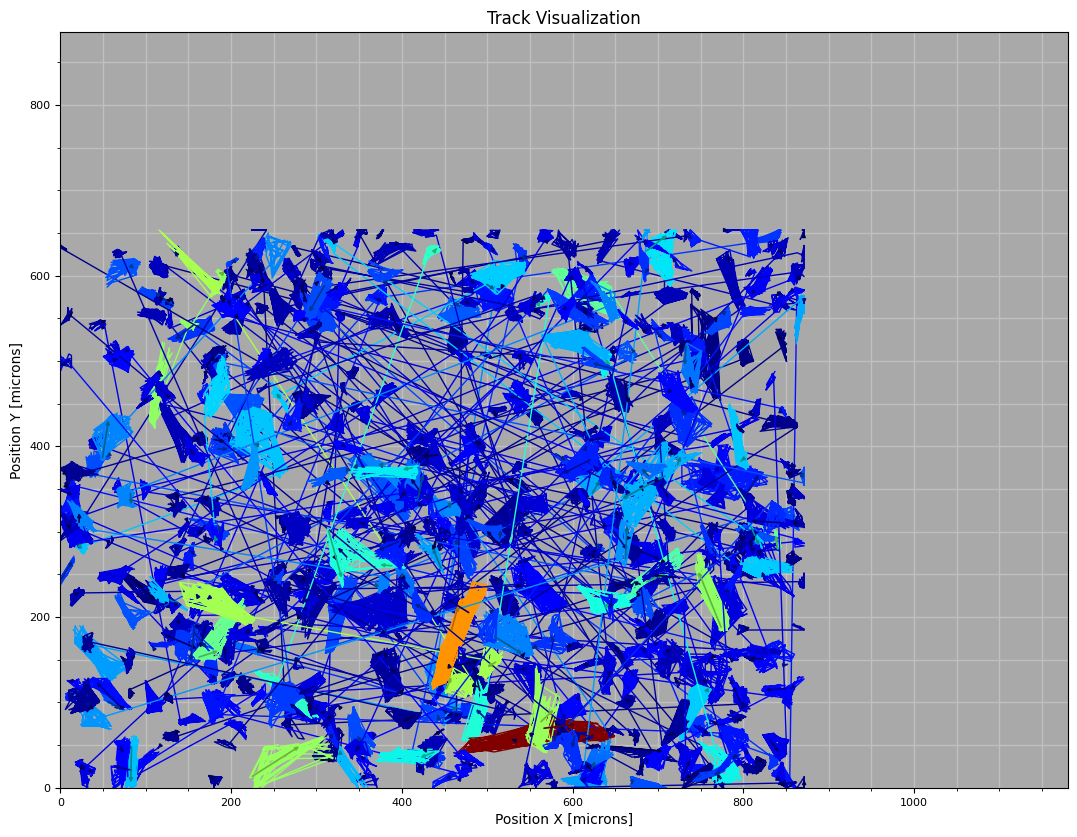

In [276]:

def track_visuals(df, df2, title_size=12):
    # fig and ax definition
    fig, ax = plt.subplots(figsize=(13, 10))

    # Ensuring that dataframse have required data
    track_ids = df2['TRACK_ID'].unique()

    # Filter df2 to only include rows where TRACK_ID is in df's track_ids
    df_filtered = df[df['TRACK_ID'].isin(track_ids)]

    net_distances = df2[['TRACK_ID', 'NET_DISTANCE']]

    # Normalize the NET_DISTANCE to a 0-1 range
    dmin = net_distances['NET_DISTANCE'].min()
    dmax = net_distances['NET_DISTANCE'].max()
    norm = plt.Normalize(vmin=dmin, vmax=dmax)
    colormap = plt.cm.jet

    # Create a dictionary to store the color for each track based on its confinement ratio
    track_colors = {}
    for track_id in track_ids:
        ratio = net_distances[net_distances['TRACK_ID'] == track_id]['NET_DISTANCE'].values[0]
        track_colors[track_id] = colormap(norm(ratio))

    # Set up the plot limits
    x_min, x_max = 0.0, 1180.3634496205236
    y_min, y_max = 0.0, 885.0880400844326
    ax.set_aspect('1', adjustable='box')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('Position X [microns]')
    ax.set_ylabel('Position Y [microns]')
    ax.set_title('Track Visualization', fontsize=title_size)
    ax.set_facecolor('darkgrey')
    ax.grid(True, which='both', axis='both', color='silver', linewidth=1)

    # Manually set the major tick locations and labels
    x_ticks_major = np.arange(x_min, x_max, 200)  # Adjust the step size as needed
    y_ticks_major = np.arange(y_min, y_max, 200)  # Adjust the step size as needed
    ax.set_xticks(x_ticks_major)
    ax.set_yticks(y_ticks_major)
    ax.set_xticklabels([f'{tick:.0f}' for tick in x_ticks_major])
    ax.set_yticklabels([f'{tick:.0f}' for tick in y_ticks_major])

    # Enable minor ticks and set their locations
    ax.minorticks_on()
    x_ticks_minor = np.arange(x_min, x_max, 50)  # Minor ticks every 50 microns
    y_ticks_minor = np.arange(y_min, y_max, 50)  # Minor ticks every 50 microns
    ax.set_xticks(x_ticks_minor, minor=True)
    ax.set_yticks(y_ticks_minor, minor=True)

    # Access and modify tick labels
    # for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    #      label.set_fontproperties(roboto_ticks)
    ax.tick_params(axis='both', which='major', labelsize=8)

    return fig, ax, track_ids, track_colors, norm, colormap

def visualize_full_tracks(df, df2, threshold, lw=1):  #Trakcs visualisation

    # Recognizing the presence of a threshold
    if threshold == None:
        threshold = '_no_threshold'
    else:
        threshold = '_' + threshold

    # Using the  track_visuals function
    fig_visuals, ax_visuals, track_ids_visuals, track_colors_visuals, norm_visuals, colormap_visuals = track_visuals(df, df2)

    # Plot the full tracks
    for track_id in track_ids_visuals:
        track_data = df[df['TRACK_ID'] == track_id]
        x = track_data['POSITION_X']
        y = track_data['POSITION_Y']
        ax_visuals.plot(x, y, lw=lw, color=track_colors_visuals[track_id], label=f'Track {track_id}')
        
        # Get the original color from track_colors_visuals[track_id]
        original_color = mcolors.to_rgb(track_colors_visuals[track_id])
        # Darken the color by reducing the brightness (by scaling each RGB channel)
        darkened_color = np.array(original_color) * 0.7  # Adjust 0.7 to a value between 0 and 1 for different darkness levels
        # Ensure that no channel goes below 0 (clip values if necessary)
        darkened_color = np.clip(darkened_color, 0, 1)
        # Apply the darkened color with a slight increase in the green and blue channels for the original factor you had (optional)
        color = darkened_color * np.array([1.0, 1.0, 0.8])  # If you want to keep the original adjustment
    

        if len(x) > 1:
            # Add arrow to indicate direction
            dx = x.diff().iloc[-1]
            dy = y.diff().iloc[-1]
            if dx != 0 or dy != 0:
                # Create an arrow instead of a circle
                arrow = FancyArrowPatch(
                    posA=(x.iloc[-2], y.iloc[-2]),  # Start position (second-to-last point)
                    posB=(x.iloc[-1], y.iloc[-1]),  # End position (last point)
                    arrowstyle='-|>',  # Style of the arrow (you can adjust the style as needed)
                    color=color,  # Set the color of the arrow
                    mutation_scale=5,  # Scale the size of the arrow head (adjust this based on the plot scale)
                    linewidth=1.2,  # Line width for the arrow
                    zorder=10  # Ensure the arrow is drawn on top of the line
                )

                # Add the arrow to your plot (if you're using a `matplotlib` figure/axes)
                plt.gca().add_patch(arrow)

    # plt.savefig(f'01a_Full_tracks_snapshot{threshold}.png', dpi=300)
    # plt.figure()
    return plt.gcf()

plt.show(visualize_full_tracks(buttered, track_data, None, lw=1))

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Function execution &#x1F3D7;
---
&#x1F6A7; *waiting to be described* &#x1F6A7;

## Thresholding &#x1F3D7;
---
[Function with defined thresholds extracting various dataframes]

&#x1F6A7; *under construction* &#x1F6A7;

In [277]:
def split_dataframe_by_percentiles(df, column_name):
    # Get to know the data frames name
    df_name = [name for name, value in globals().items() if value is df][0]

    # Dictionary to store each DataFrame filtered by percentiles
    dataframes_by_percentile = {}

    # Calculate percentiles and filter the DataFrame for each
    for percentile in range(10, 100, 10):
        threshold_value = df[column_name].quantile(percentile / 100)
        filtered_df = df[df[column_name] > threshold_value]

        # Save the DataFrame
        filename = f'{df_name}_with_{column_name}_thresholded_at_{percentile}th_percentile.csv'
        filtered_df.to_csv(op.join(save_path, filename), index=False)

        # Store in dictionary (optional)
        dataframes_by_percentile[f'threshold_at_{percentile}th_percentile'] = filtered_df

    # Accessing a specific DataFrame for, say, the 30th percentile
    df_thresholded_at_10th_percentile = dataframes_by_percentile['threshold_at_10th_percentile'] # 10th
    df_thresholded_at_20th_percentile = dataframes_by_percentile['threshold_at_20th_percentile'] # 20th
    df_thresholded_at_30th_percentile = dataframes_by_percentile['threshold_at_30th_percentile'] # 30th
    df_thresholded_at_40th_percentile = dataframes_by_percentile['threshold_at_40th_percentile'] # 40th
    df_thresholded_at_50th_percentile = dataframes_by_percentile['threshold_at_50th_percentile'] # 50th
    df_thresholded_at_60th_percentile = dataframes_by_percentile['threshold_at_60th_percentile'] # 60th
    df_thresholded_at_70th_percentile = dataframes_by_percentile['threshold_at_70th_percentile'] # 70th
    df_thresholded_at_80th_percentile = dataframes_by_percentile['threshold_at_80th_percentile'] # 80th
    df_thresholded_at_90th_percentile = dataframes_by_percentile['threshold_at_90th_percentile'] # 90th


    return df_thresholded_at_10th_percentile, df_thresholded_at_20th_percentile, df_thresholded_at_30th_percentile, df_thresholded_at_40th_percentile, df_thresholded_at_50th_percentile, df_thresholded_at_60th_percentile, df_thresholded_at_70th_percentile, df_thresholded_at_80th_percentile, df_thresholded_at_90th_percentile
Track_stats_thresholded_at_10th_percentile, Track_stats_thresholded_at_20th_percentile, Track_stats_thresholded_at_30th_percentile, Track_stats_thresholded_at_40th_percentile, Track_stats_thresholded_at_50th_percentile, Track_stats_thresholded_at_60th_percentile, Track_stats_thresholded_at_70th_percentile, Track_stats_thresholded_at_80th_percentile, Track_stats_thresholded_at_90th_percentile = split_dataframe_by_percentiles(Track_stats, 'NET_DISTANCE')

# You should try: split_dataframe_by_percentiles(df, column_name); column_name = 'NET_DISTANCE', 'TRACK_LENGTH', 'CONFINEMENT_RATIO', 'SPEED_MEDIAN AND OR MEAN, ETC 


NameError: name 'save_path' is not defined

## Visualizers, Plots, Histograms &#x1F3D7;
---
&#x1F6A7; *waiting to be described* &#x1F6A7;

---
### Defining the optic parameters
Defining the pixel length, imaging winfow parameters and aspect ratio based on the microscope:

In [ ]:
# Definition of micron length per pixel
microns_per_pixel = 0.7381885238402274 # for 10x lens

# Define the desired dimensions in microns
x_min, x_max = 0, (1600 * microns_per_pixel)
y_min, y_max = 0, (1200 * microns_per_pixel)
x_axe_remainder = x_max-1150
x_add = 50 - x_axe_remainder
y_ax_remainder = y_max-850
x_substract = (x_max - y_max) + (y_ax_remainder - 50)

# Calculate the aspect ratio
aspect_ratio = x_max / y_max

In [ ]:
title_size = 18
label_size = 11
figtext_size = 9
compass_annotations_size = 15
figtext_color = 'grey'

---
### Defining settings and the parametres for track visualization &#x1F3D7;

Defining the settings and parametres for visualization separately, so that they need not be defined over again in each of the different track visualizations

&#x1F6A7; *under construction* &#x1F6A7; 

In [ ]:
def track_visuals(df, df2):
    # fig and ax definition
    fig, ax = plt.subplots(figsize=(13, 10))

    # Ensuring that dataframse have required data
    track_ids = df2['TRACK_ID'].unique()

    # Filter df2 to only include rows where TRACK_ID is in df's track_ids
    df_filtered = df[df['TRACK_ID'].isin(track_ids)]

    net_distances = df2[['TRACK_ID', 'NET_DISTANCE']]

    # Normalize the NET_DISTANCE to a 0-1 range
    dmin = net_distances['NET_DISTANCE'].min()
    dmax = net_distances['NET_DISTANCE'].max()
    norm = plt.Normalize(vmin=dmin, vmax=dmax)
    colormap = plt.cm.jet

    # Create a dictionary to store the color for each track based on its confinement ratio
    track_colors = {}
    for track_id in track_ids:
        ratio = net_distances[net_distances['TRACK_ID'] == track_id]['NET_DISTANCE'].values[0]
        track_colors[track_id] = colormap(norm(ratio))

    # Set up the plot limits
    x_min, x_max = df_filtered['POSITION_X'].min(), df_filtered['POSITION_X'].max()
    y_min, y_max = df_filtered['POSITION_Y'].min(), df_filtered['POSITION_Y'].max()
    ax.set_aspect('1', adjustable='box')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('Position X [microns]')
    ax.set_ylabel('Position Y [microns]')
    ax.set_title('Track Visualization', fontsize=title_size)
    ax.set_facecolor('dimgrey')
    ax.grid(True, which='both', axis='both', color='grey', linewidth=1)

    # Manually set the major tick locations and labels
    x_ticks_major = np.arange(x_min, x_max, 200)  # Adjust the step size as needed
    y_ticks_major = np.arange(y_min, y_max, 200)  # Adjust the step size as needed
    ax.set_xticks(x_ticks_major)
    ax.set_yticks(y_ticks_major)
    ax.set_xticklabels([f'{tick:.0f}' for tick in x_ticks_major])
    ax.set_yticklabels([f'{tick:.0f}' for tick in y_ticks_major])

    # Enable minor ticks and set their locations
    ax.minorticks_on()
    x_ticks_minor = np.arange(x_min, x_max, 50)  # Minor ticks every 50 microns
    y_ticks_minor = np.arange(y_min, y_max, 50)  # Minor ticks every 50 microns
    ax.set_xticks(x_ticks_minor, minor=True)
    ax.set_yticks(y_ticks_minor, minor=True)
    

    # Access and modify tick labels
    # for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    #      label.set_fontproperties(roboto_ticks)
    ax.tick_params(axis='both', which='major', labelsize=8)

    return fig, ax, track_ids, track_colors, norm, colormap

---
### Visualizing the tracks &#x1F3D7;

*Overview of the tracks:*

&#x1F6A7; *under construction* &#x1F6A7; 

In [ ]:
def track_visuals(df, df2):
    # fig and ax definition
    fig, ax = plt.subplots(figsize=(13, 10))

    # Ensuring that dataframse have required data
    track_ids = df2['TRACK_ID'].unique()

    # Filter df2 to only include rows where TRACK_ID is in df's track_ids
    df_filtered = df[df['TRACK_ID'].isin(track_ids)]

    net_distances = df2[['TRACK_ID', 'NET_DISTANCE']]

    # Normalize the NET_DISTANCE to a 0-1 range
    dmin = net_distances['NET_DISTANCE'].min()
    dmax = net_distances['NET_DISTANCE'].max()
    norm = plt.Normalize(vmin=dmin, vmax=dmax)
    colormap = plt.cm.jet

    # Create a dictionary to store the color for each track based on its confinement ratio
    track_colors = {}
    for track_id in track_ids:
        ratio = net_distances[net_distances['TRACK_ID'] == track_id]['NET_DISTANCE'].values[0]
        track_colors[track_id] = colormap(norm(ratio))

    # Set up the plot limits
    x_min, x_max = df_filtered['POSITION_X'].min(), df_filtered['POSITION_X'].max()
    y_min, y_max = df_filtered['POSITION_Y'].min(), df_filtered['POSITION_Y'].max()
    ax.set_aspect('1', adjustable='box')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('Position X [microns]')
    ax.set_ylabel('Position Y [microns]')
    ax.set_title('Track Visualization', fontsize=title_size)
    ax.set_facecolor('dimgrey')

    # Manually draw rotated gridlines
    color = 'grey'     # Gridline color
    alpha = 0.2        # Gridline transparency
    lw = 0.6           # Gridline width
    grid_spacing = 50  # Adjust the spacing of gridlines
    angle1 = 45        # Rotation angle in degrees
    angle2 = -45       # Rotation angle in degrees
    z_order = 0.5      # Gridline z-order

    for x in np.arange(x_min, x_max, grid_spacing):
        for y in np.arange(y_min, y_max, grid_spacing):
            # Compute the rotated line endpoints
            x_lines_a = [x, x + (y_max - y_min) * np.tan(np.radians(angle1))]
            y_lines_a = [y, y + (x_max - x_min) * np.tan(np.radians(angle1))]
            x_lines_b = [x, x + (y_max - y_min) * np.tan(np.radians(angle2))]
            y_lines_b = [y, y + (x_max - x_min) * np.tan(np.radians(angle2))]
            ax.plot(x_lines_a, [y_min, y_max], color=color, linestyle='-', linewidth=lw, alpha=alpha, zorder=z_order)
            ax.plot(y_lines_a, [(x_max+x_add), (x_min+x_add)], color=color, linestyle='-', linewidth=lw, alpha=alpha, zorder=z_order)
            ax.plot(x_lines_b, [y_min, y_max], color=color, linestyle='-', linewidth=lw, alpha=alpha, zorder=z_order)
            ax.plot(y_lines_b, [(x_max - x_substract), (x_min - x_substract)], color=color, linestyle='-', linewidth=lw, alpha=alpha, zorder=z_order)

    # Standard gridlines (optional)
    ax.grid(False)  # Turn off default gridlines


    # Manually set the major tick locations and labels
    x_ticks_major = np.arange(x_min, x_max, 200)  # Adjust the step size as needed
    y_ticks_major = np.arange(y_min, y_max, 200)  # Adjust the step size as needed
    ax.set_xticks(x_ticks_major)
    ax.set_yticks(y_ticks_major)
    ax.set_xticklabels([f'{tick:.0f}' for tick in x_ticks_major])
    ax.set_yticklabels([f'{tick:.0f}' for tick in y_ticks_major])

    # Enable minor ticks and set their locations
    ax.minorticks_on()
    x_ticks_minor = np.arange(x_min, x_max, 50)  # Minor ticks every 50 microns
    y_ticks_minor = np.arange(y_min, y_max, 50)  # Minor ticks every 50 microns
    ax.set_xticks(x_ticks_minor, minor=True)
    ax.set_yticks(y_ticks_minor, minor=True)
    

    # Access and modify tick labels
    # for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    #      label.set_fontproperties(roboto_ticks)
    ax.tick_params(axis='both', which='major', labelsize=8)

    return fig, ax, track_ids, track_colors, norm, colormap

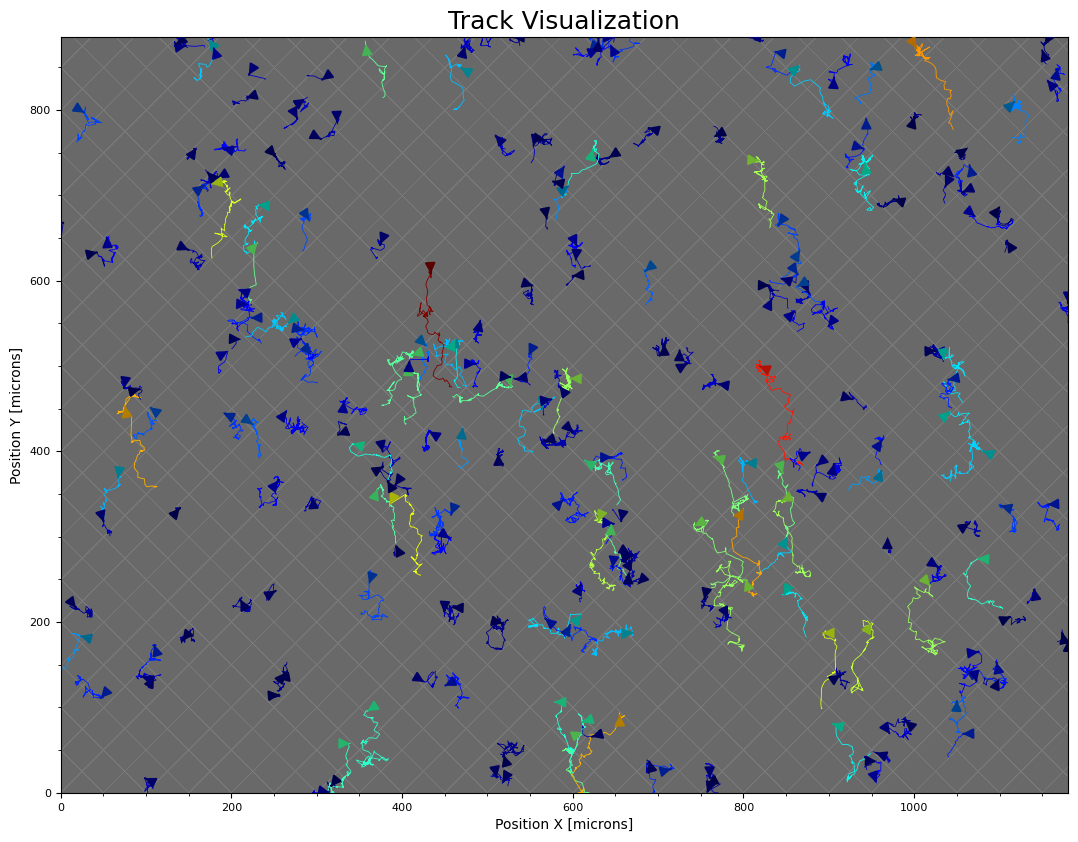

In [ ]:
def visualize_full_tracks(df, df2, threshold, lw=1):  #Trakcs visualisation

    # Recognizing the presence of a threshold
    if threshold == None:
        threshold = '_no_threshold'
    else:
        threshold = '_' + threshold

    # Using the  track_visuals function
    fig_visuals, ax_visuals, track_ids_visuals, track_colors_visuals, norm_visuals, colormap_visuals = track_visuals(df, df2)

    # Plot the full tracks
    for track_id in track_ids_visuals:
        track_data = df[df['TRACK_ID'] == track_id]
        x = track_data['POSITION_X']
        y = track_data['POSITION_Y']
        ax_visuals.plot(x, y, lw=lw, color=track_colors_visuals[track_id], label=f'Track {track_id}')
        
        # Get the original color from track_colors_visuals[track_id]
        original_color = mcolors.to_rgb(track_colors_visuals[track_id])
        # Darken the color by reducing the brightness (by scaling each RGB channel)
        darkened_color = np.array(original_color) * 0.7  # Adjust 0.7 to a value between 0 and 1 for different darkness levels
        # Ensure that no channel goes below 0 (clip values if necessary)
        darkened_color = np.clip(darkened_color, 0, 1)
        # Apply the darkened color with a slight increase in the green and blue channels for the original factor you had (optional)
        color = darkened_color * np.array([1.0, 1.0, 0.8])  # If you want to keep the original adjustment
    

        if len(x) > 1:
            # Add arrow to indicate direction
            dx = x.diff().iloc[-1]
            dy = y.diff().iloc[-1]
            if dx != 0 or dy != 0:
                # Create an arrow instead of a circle
                arrow = FancyArrowPatch(
                    posA=(x.iloc[-2], y.iloc[-2]),  # Start position (second-to-last point)
                    posB=(x.iloc[-1], y.iloc[-1]),  # End position (last point)
                    arrowstyle='-|>',  # Style of the arrow (you can adjust the style as needed)
                    color=color,  # Set the color of the arrow
                    mutation_scale=15,  # Scale the size of the arrow head (adjust this based on the plot scale)
                    linewidth=1.5,  # Line width for the arrow
                    zorder=10  # Ensure the arrow is drawn on top of the line
                )

                # Add the arrow to your plot (if you're using a `matplotlib` figure/axes)
                plt.gca().add_patch(arrow)

    plt.savefig((op.join(save_path, f'01a_Full_tracks_snapshot{threshold}.png')), dpi=300)
    # plt.show()
visualize_full_tracks(butter_df, Track_stats, None, lw=0.6)
# visualize_full_tracks(butter_df, Track_stats_thresholded_at_20th_percentile, 'thresholded_at_20th_percentile') # 20th
# visualize_full_tracks(butter_df, Track_stats_thresholded_at_40th_percentile, 'thresholded_at_40th_percentile') # 40th
# visualize_full_tracks(butter_df, Track_stats_thresholded_at_60th_percentile, 'thresholded_at_60th_percentile') # 60th
# visualize_full_tracks(butter_df, Track_stats_thresholded_at_80th_percentile, 'thresholded_at_80th_percentile') # 80th
# visualize_full_tracks(butter_df, Track_stats_thresholded_at_90th_percentile, 'thresholded_at_90th_percentile') # 90th

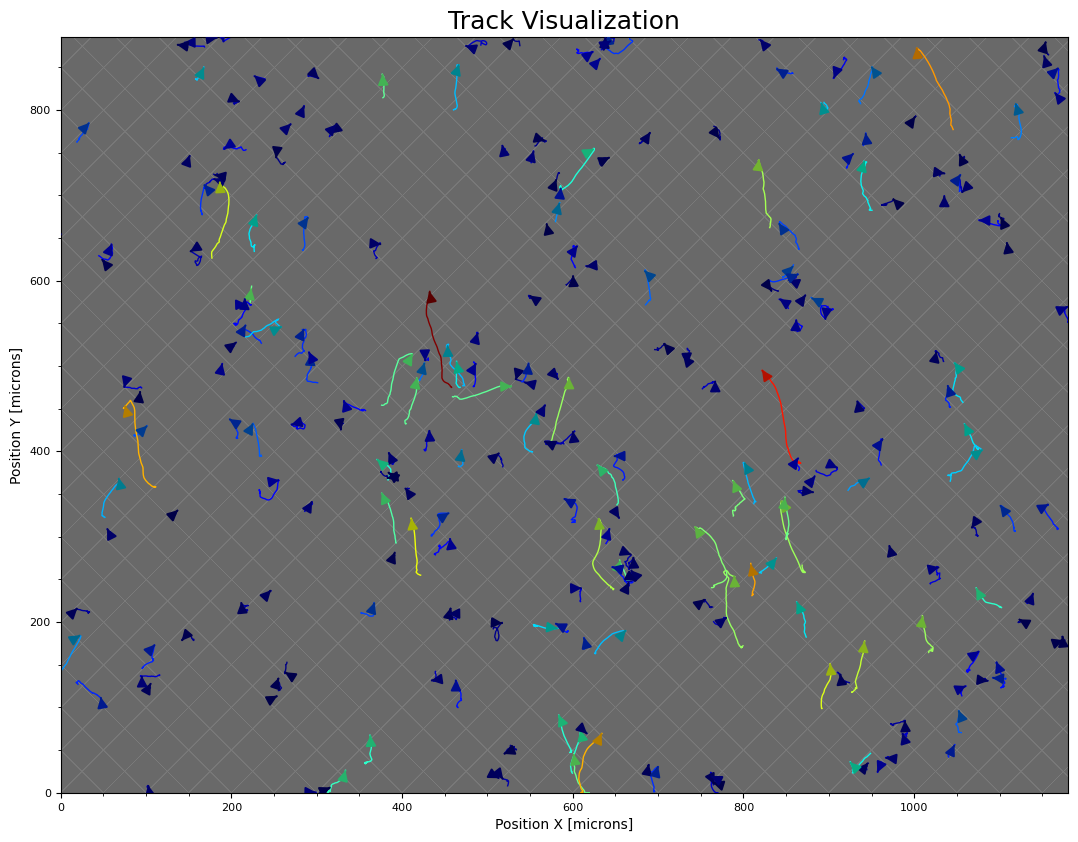

In [ ]:
def visualize_smoothed_tracks(df, df2, threshold, smoothing_type=None, smoothing_index=10, lw=1):  # Tracks visualization

    # Recognizing the presence of a threshold
    if threshold is None:
        threshold = '_no_threshold'
    else:
        threshold = '_' + threshold

    # Using the track_visuals function
    fig_visuals, ax_visuals, track_ids_visuals, track_colors_visuals, norm_visuals, colormap_visuals = track_visuals(df, df2)

    # Plot the full tracks
    for track_id in track_ids_visuals:
        track_data = df[df['TRACK_ID'] == track_id]
        x = track_data['POSITION_X']
        y = track_data['POSITION_Y']
        
        # Apply smoothing to the track (if applicable)
        if smoothing_type == 'moving_average':
            x_smoothed = x.rolling(window=smoothing_index, min_periods=1).mean()
            y_smoothed = y.rolling(window=smoothing_index, min_periods=1).mean()
        else:
            x_smoothed = x
            y_smoothed = y

        ax_visuals.plot(x_smoothed, y_smoothed, lw=lw, color=track_colors_visuals[track_id], label=f'Track {track_id}')

        # Get the original color from track_colors_visuals[track_id]
        original_color = mcolors.to_rgb(track_colors_visuals[track_id])
        # Darken the color by reducing the brightness (by scaling each RGB channel)
        darkened_color = np.array(original_color) * 0.7  # Adjust 0.7 to a value between 0 and 1 for different darkness levels
        # Ensure that no channel goes below 0 (clip values if necessary)
        darkened_color = np.clip(darkened_color, 0, 1)
        # Apply the darkened color with a slight increase in the green and blue channels for the original factor you had (optional)
        color = darkened_color * np.array([1.0, 1.0, 0.8])  # If you want to keep the original adjustment


        if len(x_smoothed) > 1:
            # Extract the mean direction from df2 for the current track
            mean_direction_rad = df2[df2['TRACK_ID'] == track_id]['MEAN_DIRECTION_RAD'].values[0]
            
            # Use trigonometry to calculate the direction (dx, dy) from the angle
            dx = np.cos(mean_direction_rad)  # Change in x based on angle
            dy = np.sin(mean_direction_rad)  # Change in y based on angle
            
            # Create an arrow to indicate direction
            arrow = FancyArrowPatch(
                posA=(x_smoothed.iloc[-2], y_smoothed.iloc[-2]),  # Start position (second-to-last point)
                posB=(x_smoothed.iloc[-2] + dx, y_smoothed.iloc[-2] + dy),  # End position based on direction
                arrowstyle='-|>',  # Style of the arrow (you can adjust the style as needed)
                color=color,  # Set the color of the arrow
                mutation_scale=15,  # Scale the size of the arrow head (adjust this based on the plot scale)
                linewidth=1.5,  # Line width for the arrow
                zorder=30  # Ensure the arrow is drawn on top of the line
            )

            # Add the arrow to your plot (if you're using a `matplotlib` figure/axes)
            plt.gca().add_patch(arrow)

    plt.savefig((op.join(save_path, f'01a_Full_tracks_snapshot{threshold}.png')), dpi=300)
    # plt.show()

# Example usage
visualize_smoothed_tracks(butter_df, Track_stats, None, smoothing_type='moving_average', smoothing_index=50, lw=1)


---
### Histograms describing cell motility &#x1F3D7;

*Histogram plotting all cells in the dataset and its migrated distance together with the time window in which it has been imaged:*

&#x1F6A7; *under construction* &#x1F6A7; 

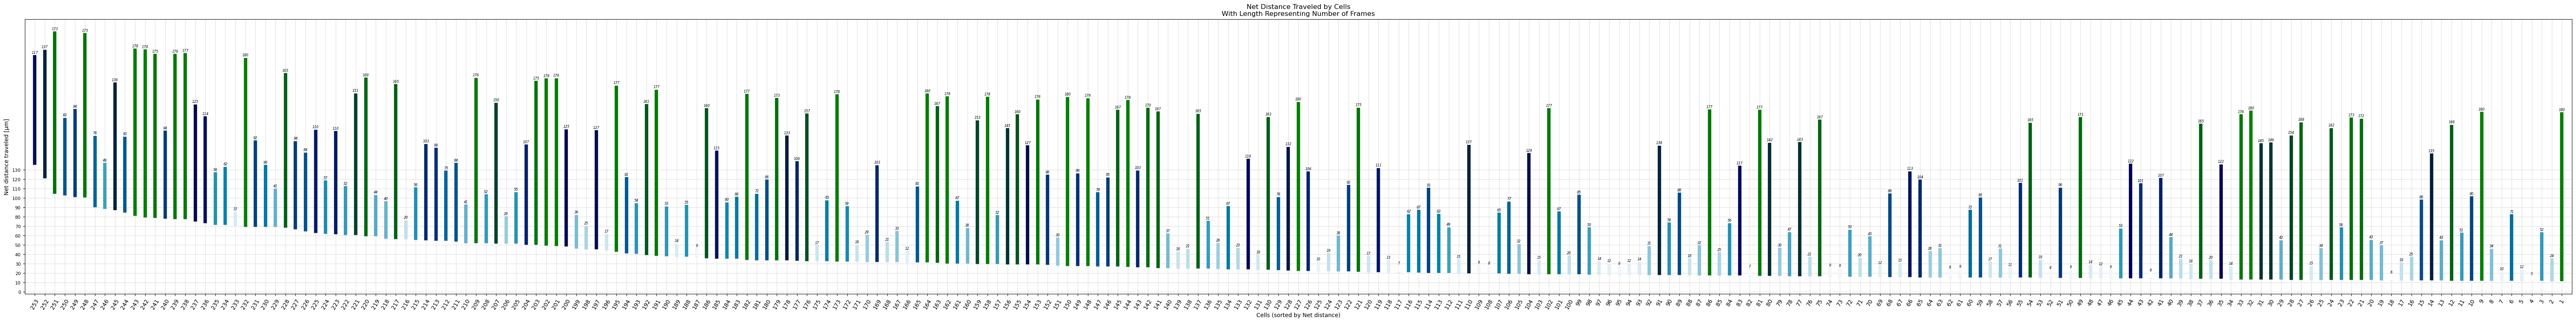

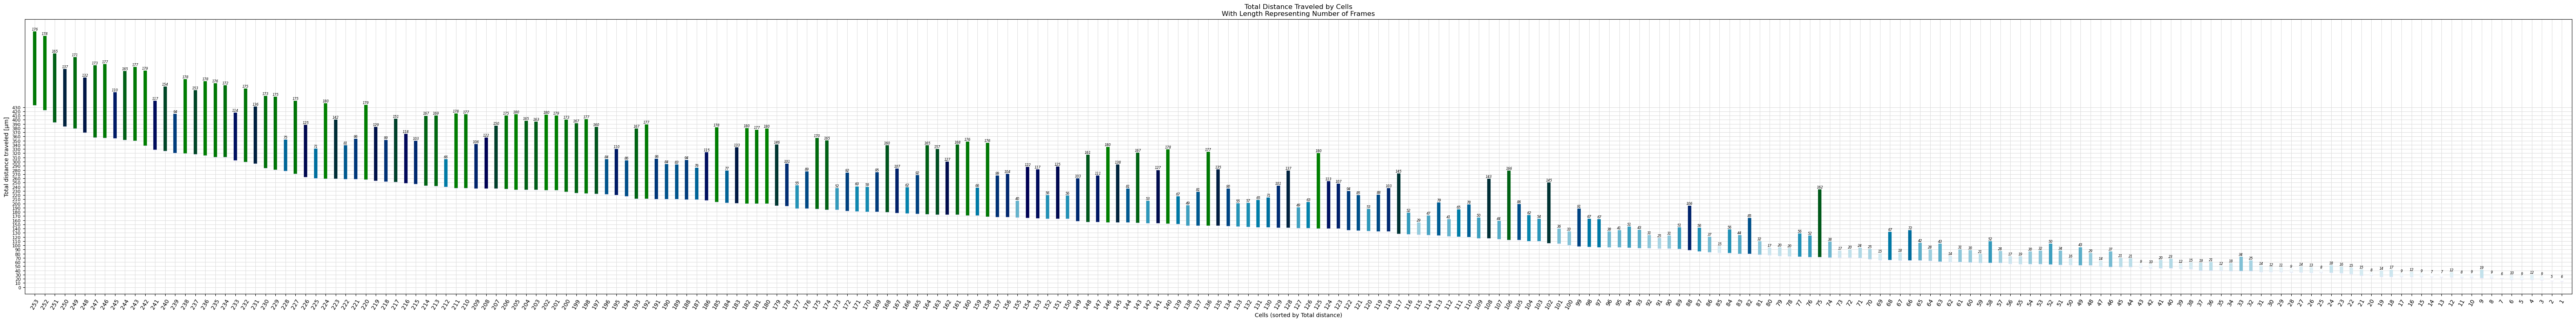

In [ ]:

def histogram_cells_distance(df, metric, str):
    
    # Sort the DataFrame by 'TRACK_LENGTH' in ascending order
    df_sorted = df.sort_values(by=metric)

    norm = mcolors.Normalize(vmin=df_sorted["NUM_FRAMES"].min(), vmax=df_sorted["NUM_FRAMES"].max())
    cmap = plt.colormaps["ocean_r"]

    # Create new artificial IDs for sorting purposes (1 for lowest distance, N for highest)
    df_sorted["Artificial_ID"] = range(1, len(df_sorted) + 1)

    x_span = PlotParams.x_span(df_sorted)

    # Create the figure and axis for the plot
    fig, ax = plt.subplots(figsize=(x_span, 8))
    fig.set_tight_layout(True)
    width = 6

    # Loop through each row to plot each cell's data
    for idx, row in df_sorted.iterrows():
        artificial_id = row["Artificial_ID"]
        track_length = row[metric]
        num_frames = row["NUM_FRAMES"]

        # Get the color based on the number of frames using the viridis colormap
        line_color = cmap(norm(num_frames))

        # Plot the "chimney" or vertical line
        ax.vlines(
            x=artificial_id,  # X position for the cell
            ymin=track_length,  # Starting point of the line (y position)
            ymax=track_length + num_frames,  # End point based on number of frames (height)
            color=line_color,
            linewidth=width,
            )

        plt.plot(artificial_id, track_length, '_', zorder=5, color="lavender")

        # Add the mean number of frames as text above each chimney
        ax.text(
        artificial_id,  # X position (same as the chimney)
        track_length + num_frames + 1,  # Y position (slightly above the chimney)
        f"{round(num_frames)}",  # The text to display (formatted mean)
        ha='center',  # Horizontal alignment center
        va='bottom',  # Vertical alignment bottom
        fontsize=6,  # Adjust font size if necessary
        color='black',  # Color of the text
        style='italic'  # Italicize the text
        )

        x = int(row['Artificial_ID'])

        plt.xticks(range(x), rotation=90) # add loads of ticks
        plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
        plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)


    max_y = df_sorted[metric].max()
    num_x_values = df_sorted[metric].count()

    # Adjust the plot aesthetics
    plt.tick_params(axis='x', rotation=60)
    plt.tick_params(axis='y', labelsize=8)
    plt.xticks(range(num_x_values)) # add loads of ticks
    plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
    plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)

    # Set ticks, labels and title
    ax.set_xticks(range(1, num_x_values + 1))
    ax.set_yticks(np.arange(0, max_y + 1, 10))
    ax.set_xlabel(f"Cells (sorted by {str} distance)")
    ax.set_ylabel(f"{str} distance traveled [μm]")
    ax.set_title(f"{str} Distance Traveled by Cells\nWith Length Representing Number of Frames")

    # Invert x-axis so the highest distance is on the left
    plt.gca().invert_xaxis()

    ax.set_xlim(right=0, left=num_x_values+1)  # Adjust the left limit as needed

    # Show the plot
    plt.savefig(op.join(save_path, f"02f_Histogram_{str}_distance_traveled_per_cell.png"))
    plt.show()
histogram_cells_distance(Track_stats, 'NET_DISTANCE', 'Net')
histogram_cells_distance(Track_stats, 'TRACK_LENGTH', 'Total')

---
*Histogram plotting percentile groups in the cell dataset - migrated distance together with the time window in which it has been imaged:*

&#x1F6A7; *under construction* &#x1F6A7; 

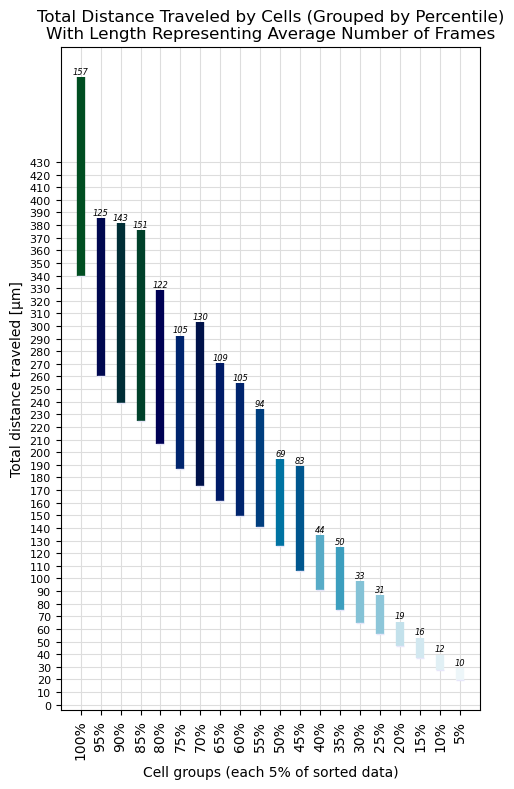

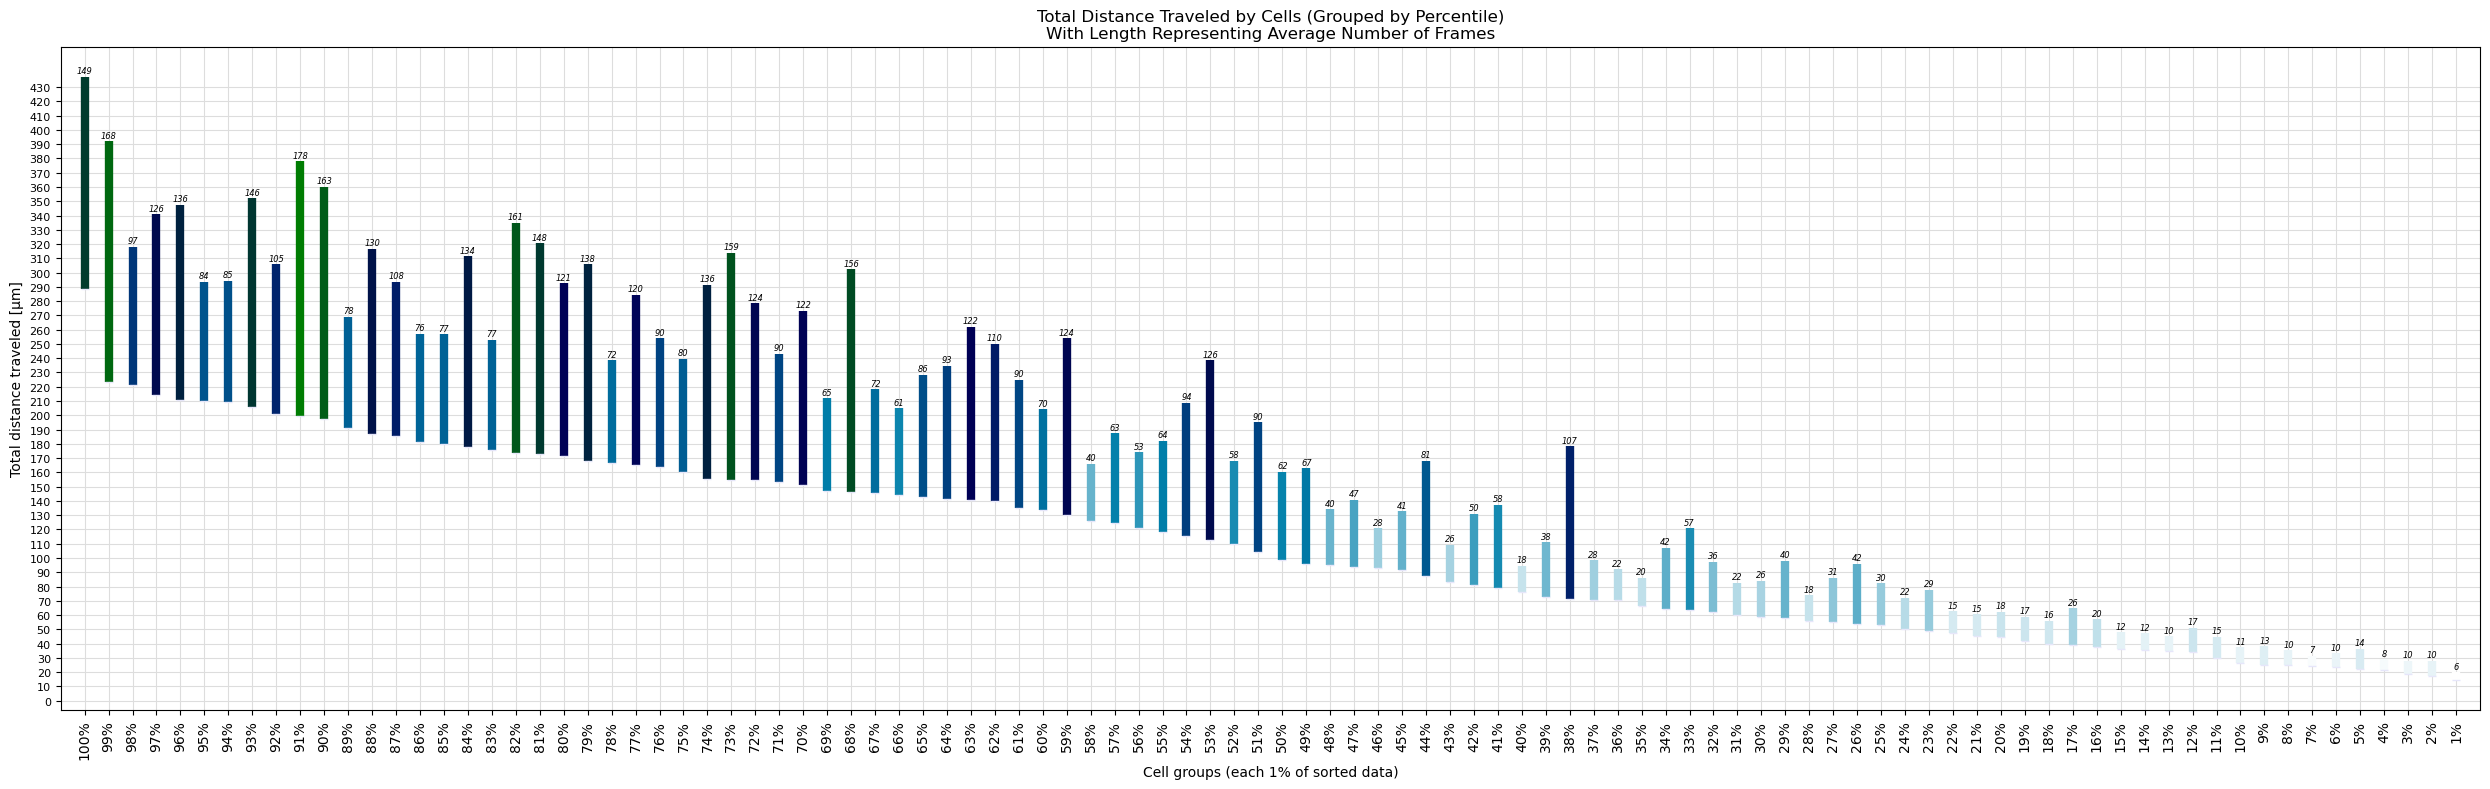

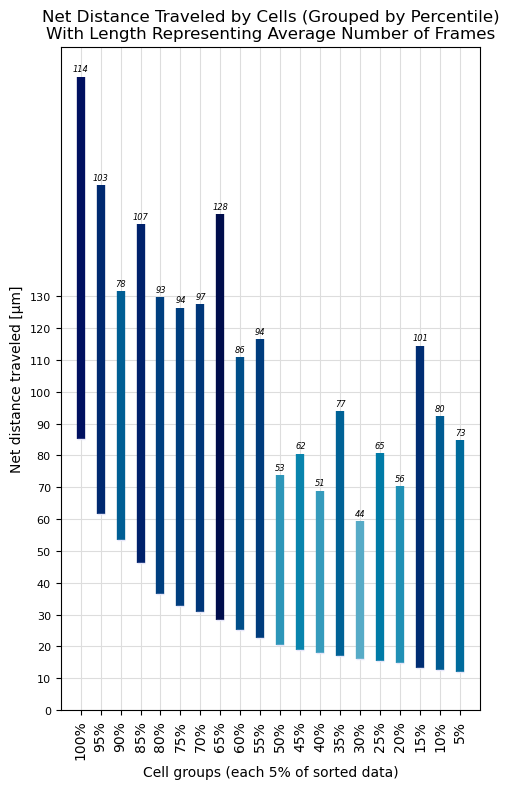

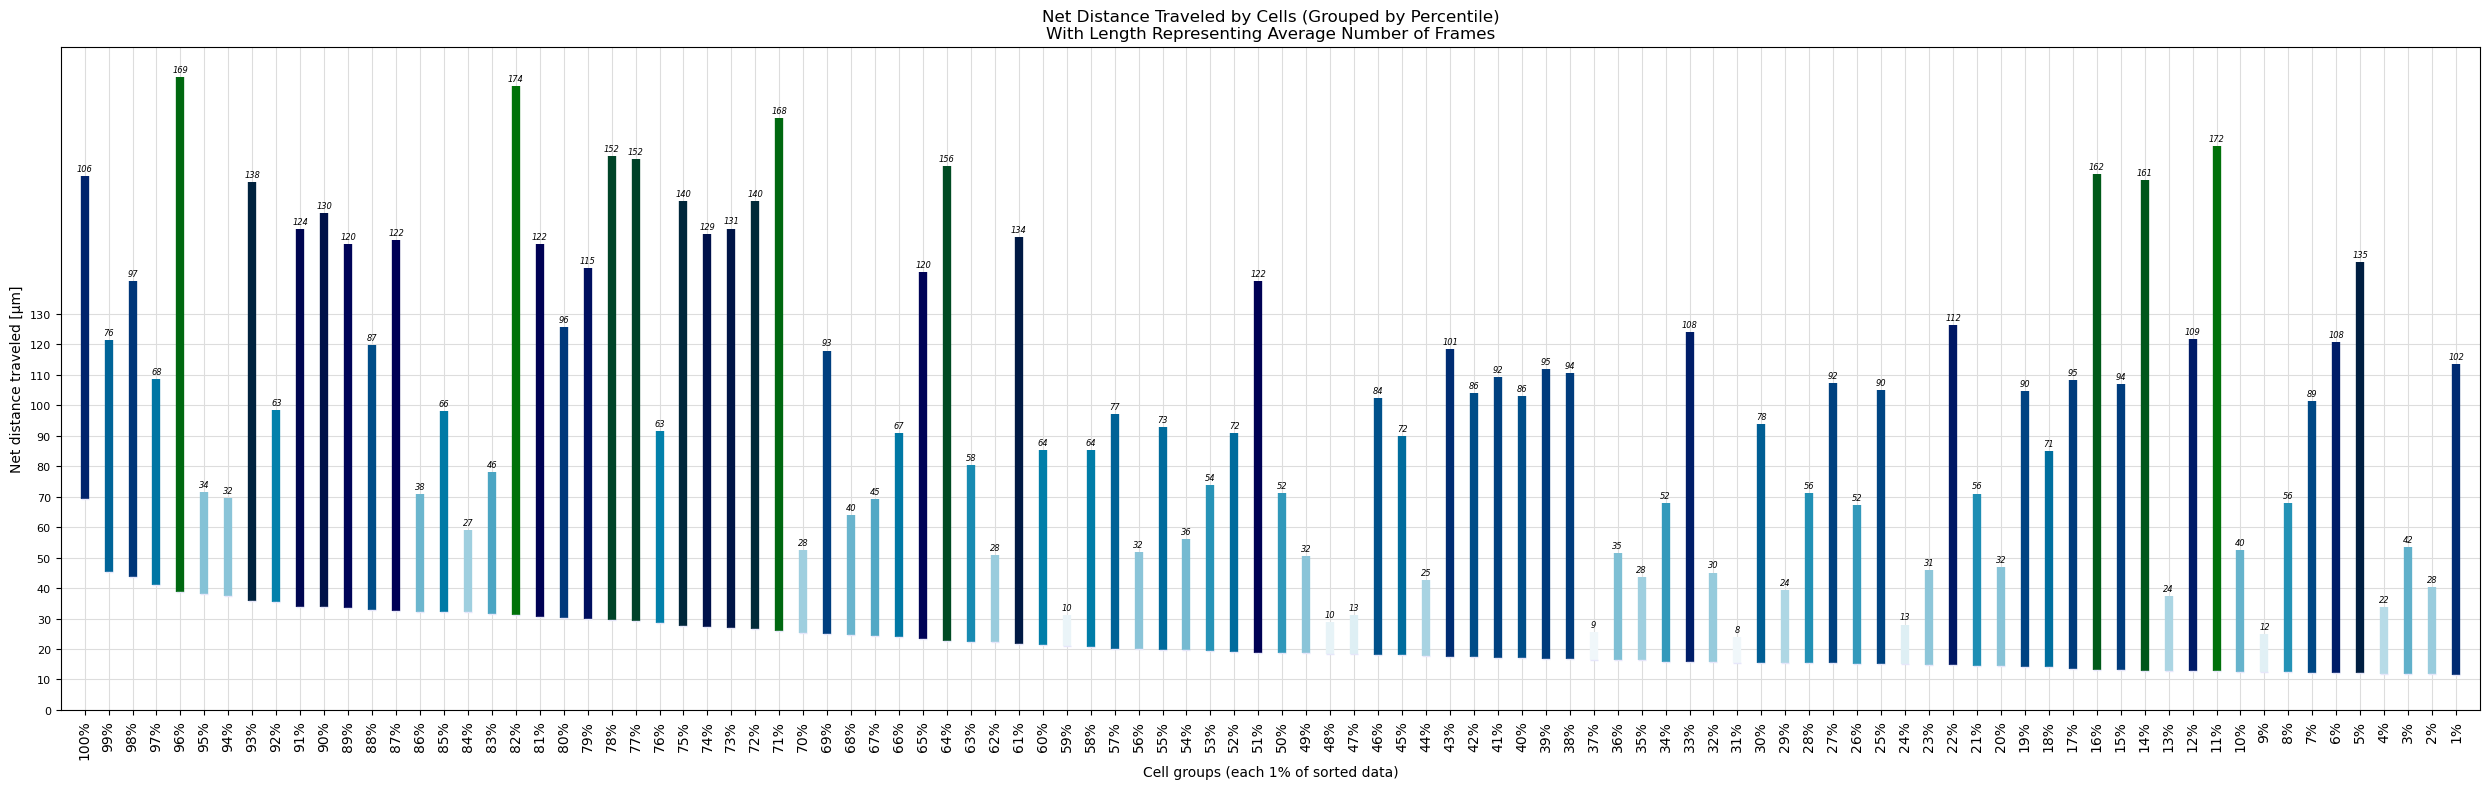

In [ ]:
def histogram_nth_percentile_distance(df, metric, num_groups, percentiles, str, threshold):

    # Recognizing the presence of a threshold
    if threshold == None:
        threshold = '_no_threshold'
    else:
        threshold = '_' + threshold

    # Sort the DataFrame by 'NET_DISTANCE' in ascending order
    df_sorted = df.sort_values(by=metric)

    # Number of groups (chimneys) and size of each group (5% each)
    group_size = len(df_sorted) // num_groups

    x_span = num_groups * 0.25

    # Create the figure and axis for the plot
    fig, ax = plt.subplots(figsize=(x_span, 8))
    fig.set_tight_layout(True)
    width = 6

    # Normalize the 'NUM_FRAMES' column for color mapping
    norm = mcolors.Normalize(vmin=df_sorted["NUM_FRAMES"].min(), vmax=df_sorted["NUM_FRAMES"].max())
    cmap = plt.colormaps["ocean_r"]

    # Loop over each group and plot the aggregate statistics
    for i in range(num_groups):
        # Define group indices
        group_start = i * group_size
        group_end = (i + 1) * group_size if i != num_groups - 1 else len(df_sorted)

        # Get the current group data
        group_data = df_sorted.iloc[group_start:group_end]

        # Calculate the aggregate statistics for the group
        group_mean_distance = group_data[metric].mean()
        group_mean_frames = group_data["NUM_FRAMES"].mean()

        # Set x-position of the group (e.g., center it based on group index)
        group_x = i + 1

        # Get the color based on the average number of frames in the group
        line_color = cmap(norm(group_mean_frames))

        # Plot the "chimney" representing the group
        ax.vlines(
            x=group_x,  # X position for the group
            ymin=group_mean_distance,  # Starting point of the line (y position)
            ymax=group_mean_distance + group_mean_frames,  # End point based on average number of frames (height)
            color=line_color,
            linewidth=width,
            )

        plt.plot(group_x, group_mean_distance, '_', zorder=5, color="lavender")

        # Add the mean number of frames as text above each chimney
        ax.text(
            group_x,  # X position (same as the chimney)
            group_mean_distance + group_mean_frames + 1,  # Y position (slightly above the chimney)
            f'{round(group_mean_frames)}',  # The text to display (formatted mean)
            ha='center',  # Horizontal alignment center
            va='bottom',  # Vertical alignment bottom
            fontsize=6,  # Adjust font size if necessary
            color='black',  # Color of the text
            style='italic'
            )

    max_y = df_sorted[metric].max() 

    # Adjust the plot aesthetics
    plt.xticks(range(group_x)) # add loads of ticks
    plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
    plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)

    plt.tick_params(axis='x', rotation=60)
    plt.tick_params(axis='y', labelsize=8) 

    ax.set_xticks(range(1, num_groups + 1))
    ax.set_xticklabels([f"{percentiles * (i + 1)}%" for i in range(num_groups)], rotation=90)
    ax.set_yticks(np.arange(0, max_y + 1, 10))
    ax.set_xlabel(f"Cell groups (each {percentiles}% of sorted data)")
    ax.set_ylabel(f"{str} distance traveled [μm]")
    ax.set_title(f"{str} Distance Traveled by Cells (Grouped by Percentile)\nWith Length Representing Average Number of Frames")
    ax.grid(which="major", color="#DDDDDD", linewidth=0.8)
    ax.grid(which="minor", color="#EEEEEE", linestyle=":", linewidth=0.5)

    # Invert x-axis so the highest distance is on the left
    ax.invert_xaxis()

    ax.set_xlim(right=0, left=num_groups+1)  # Adjust the left limit as needed

    # Show the plot
    plt.savefig((op.join(save_path, f"02f_Histogram_{str}_distance_traveled_{percentiles}th_percentiles{threshold}.png")))
    plt.show()
histogram_nth_percentile_distance(Track_stats, 'TRACK_LENGTH', 20, 5, 'Total', None)
histogram_nth_percentile_distance(Track_stats, 'TRACK_LENGTH', 100, 1, 'Total', None)
histogram_nth_percentile_distance(Track_stats, 'NET_DISTANCE', 20, 5, 'Net', None)
histogram_nth_percentile_distance(Track_stats, 'NET_DISTANCE', 100, 1, 'Net', None)
# histogram_nth_percentile_distance(Track_stats_thresholded_at_20th_percentile, 'TRACK_LENGTH', 20, 5, 'Total', 'thresholded_at_20th_percentile') # 20th
# histogram_nth_percentile_distance(Track_stats_thresholded_at_20th_percentile, 'NET_DISTANCE', 20, 5, 'Net', 'thresholded_at_20th_percentile')
# histogram_nth_percentile_distance(Track_stats_thresholded_at_40th_percentile, 'TRACK_LENGTH', 20, 5, 'Total', 'thresholded_at_40th_percentile') # 40th
# histogram_nth_percentile_distance(Track_stats_thresholded_at_40th_percentile, 'NET_DISTANCE', 20, 5, 'Net', 'thresholded_at_40th_percentile')
# histogram_nth_percentile_distance(Track_stats_thresholded_at_60th_percentile, 'TRACK_LENGTH', 20, 5, 'Total', 'thresholded_at_60th_percentile') # 60th
# histogram_nth_percentile_distance(Track_stats_thresholded_at_60th_percentile, 'NET_DISTANCE', 20, 5, 'Net', 'thresholded_at_60th_percentile')
# histogram_nth_percentile_distance(Track_stats_thresholded_at_80th_percentile, 'TRACK_LENGTH', 20, 5, 'Total', 'thresholded_at_80th_percentile') # 80th
# histogram_nth_percentile_distance(Track_stats_thresholded_at_80th_percentile, 'NET_DISTANCE', 20, 5, 'Net', 'thresholded_at_80th_percentile')

---
*Histogram plotting the median and mean speed of migration per frame* &#x1F3D7;

&#x1F6A7; *under heavy construction* &#x1F6A7; 

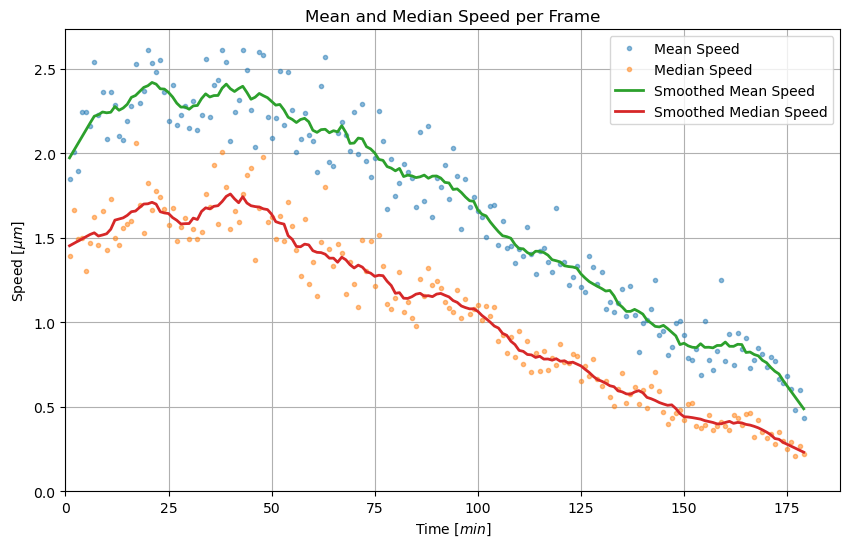

In [ ]:
frames = Frame_stats['POSITION_T'][1:-1]
mean_speed = Frame_stats['SPEED_MEAN'][1:-1]
median_speed = Frame_stats['SPEED_MEDIAN'][1:-1]

# Apply Savitzky-Golay filter for smoothing
mean_speed_smooth = savgol_filter(mean_speed, window_length=11, polyorder=1)
median_speed_smooth = savgol_filter(median_speed, window_length=11, polyorder=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(frames, mean_speed, '.', label='Mean Speed', alpha=0.5)
plt.plot(frames, median_speed, '.', label='Median Speed', alpha=0.5)
plt.plot(frames, mean_speed_smooth, '-', label='Smoothed Mean Speed', linewidth=2)
plt.plot(frames, median_speed_smooth, '-', label='Smoothed Median Speed', linewidth=2)

# Set x-axis to start at 0
plt.xlim(left=0)
plt.ylim(bottom=0)

plt.xlabel(r'Time $\it{[min]}$')
plt.ylabel(r'Speed $\it{[μm]}$')
plt.title('Mean and Median Speed per Frame')
plt.legend()
plt.grid(True)
plt.show()

---


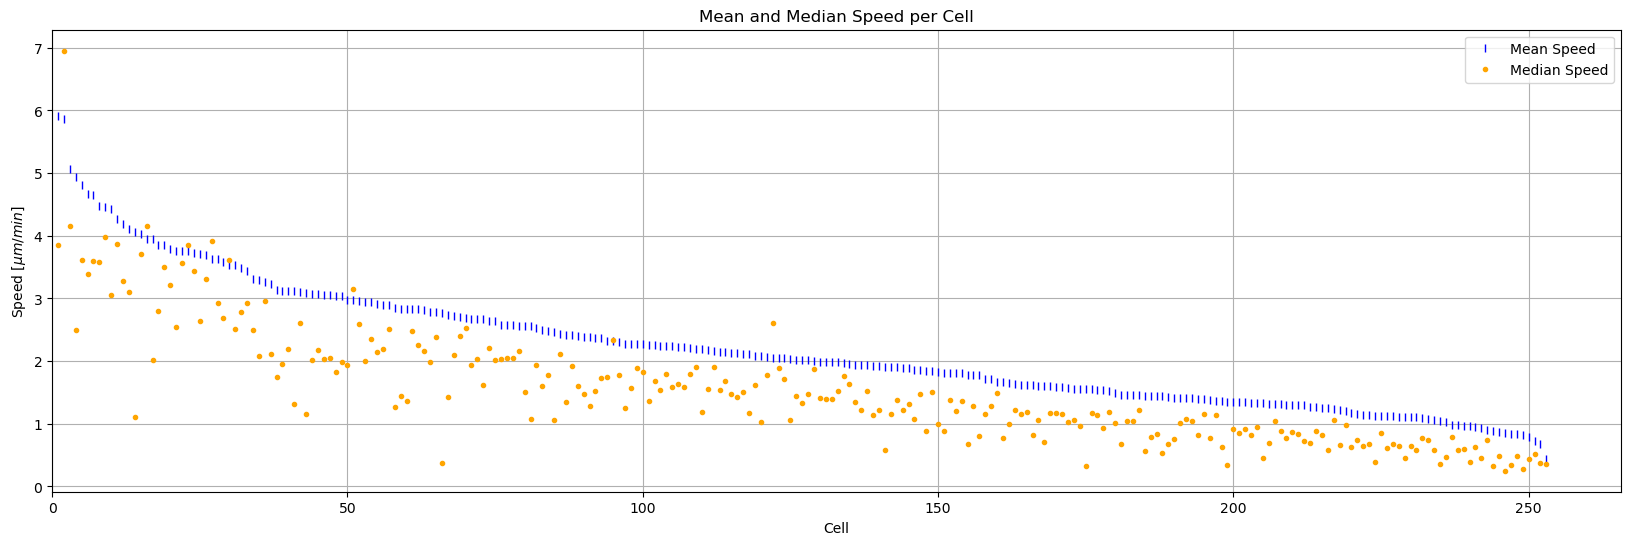

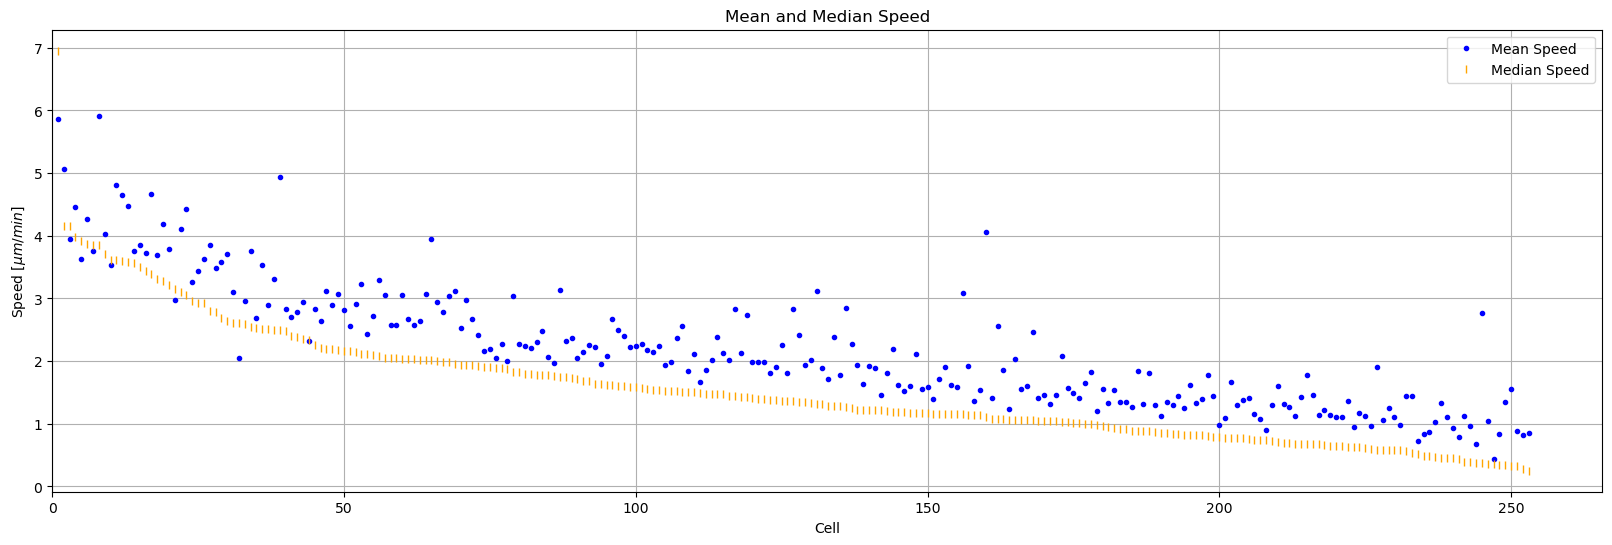

In [ ]:
# Sort the DataFrame by 'TRACK_LENGTH' in ascending order
df_sorted_a = Track_stats.sort_values(by='SPEED_MEAN', ascending=False)
df_sorted_b = Track_stats.sort_values(by='SPEED_MEDIAN', ascending=False)

# Create new artificial IDs for sorting purposes (1 for lowest distance, N for highest)
df_sorted_a["Artificial_ID"] = range(1, len(df_sorted_a) + 1)
df_sorted_b["Artificial_ID"] = range(1, len(df_sorted_b) + 1)

# defining variables
cell_id_a = df_sorted_a["Artificial_ID"]
mean_speed_a = df_sorted_a['SPEED_MEAN']
median_speed_a = df_sorted_a['SPEED_MEDIAN']

cell_id_b = df_sorted_b["Artificial_ID"]
mean_speed_b = df_sorted_b['SPEED_MEAN']
median_speed_b = df_sorted_b['SPEED_MEDIAN']

# mean_speed_smooth = savgol_filter(mean_speed_a, window_length=11, polyorder=1)
# median_speed_smooth = savgol_filter(median_speed_b, window_length=11, polyorder=1)



x_span = PlotParams.x_span(Track_stats4_df, 0.08)

# Plotting no. 1
plt.figure(figsize=(x_span, 6))
plt.plot(cell_id_a, mean_speed_a, '|', label='Mean Speed', color='blue')
plt.plot(cell_id_a, median_speed_a, '.', label='Median Speed', color='orange')
# plt.plot(cell_id_a, mean_speed_smooth, '-', label='Mean Speed', linewidth=2, color='blue', zorder=1)

# Set x-axis to start at 0
plt.xlim(left=0)

plt.xlabel('Cell')
plt.ylabel(r'Speed $\it{[μm/min]}$')
plt.title('Mean and Median Speed per Cell')
plt.legend()
plt.grid(True)
plt.show()


# Plotting no. 2
plt.figure(figsize=(20, 6))
plt.plot(cell_id_b, mean_speed_b, '.', label='Mean Speed', color='blue')
plt.plot(cell_id_b, median_speed_b, '|', label='Median Speed', color='orange')
# plt.plot(cell_id_b, median_speed_smooth, '-', label='Median Speed', linewidth=2, color='orange', zorder=1)

# Set x-axis to start at 0
plt.xlim(left=0)

plt.xlabel('Cell')
plt.ylabel(r'Speed $\it{[μm/min]}$')
plt.title('Mean and Median Speed')
plt.legend()
plt.grid(True)
plt.show()

---
### Plotting the direction of migration &#x1F3D7;
&#x1F6A7; *under construction* &#x1F6A7; 

<>:94: SyntaxWarning: invalid escape sequence '\i'
<>:94: SyntaxWarning: invalid escape sequence '\i'
C:\Users\modri\AppData\Local\Temp\ipykernel_13740\3041876227.py:94: SyntaxWarning: invalid escape sequence '\i'
  ax.set_title(f'Mean Direction of Travel with Kernel Density Estimate\n$\it{{{subject}}}$', fontsize=title_size)


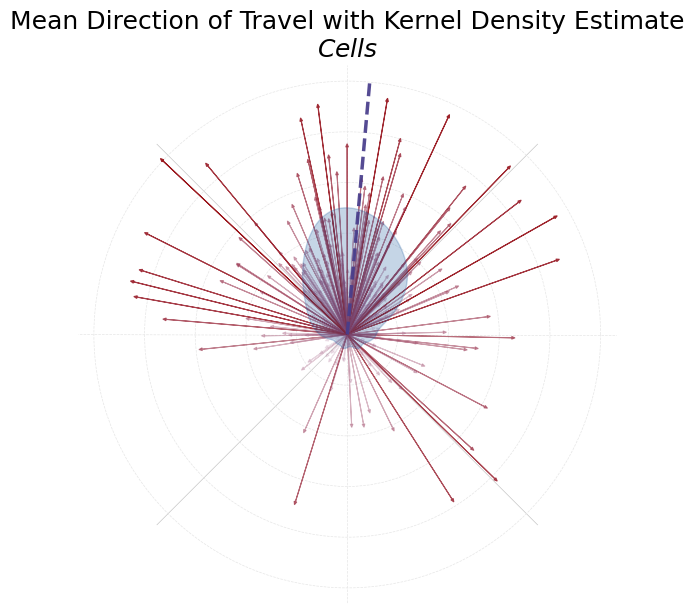

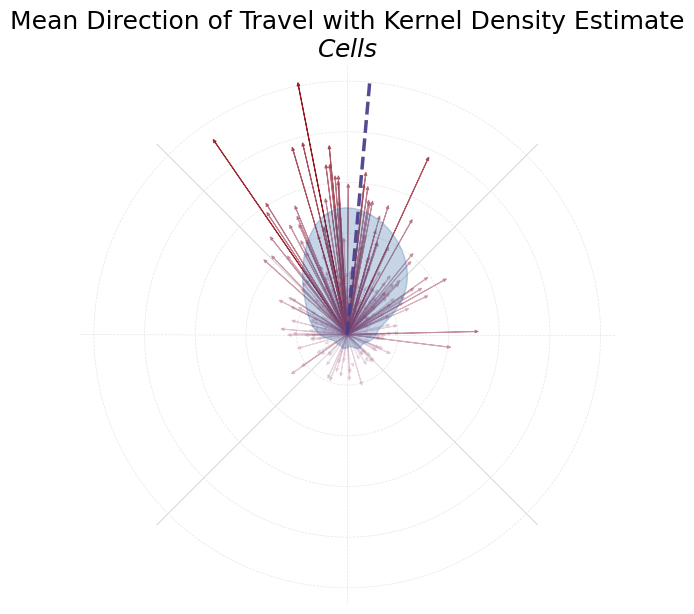

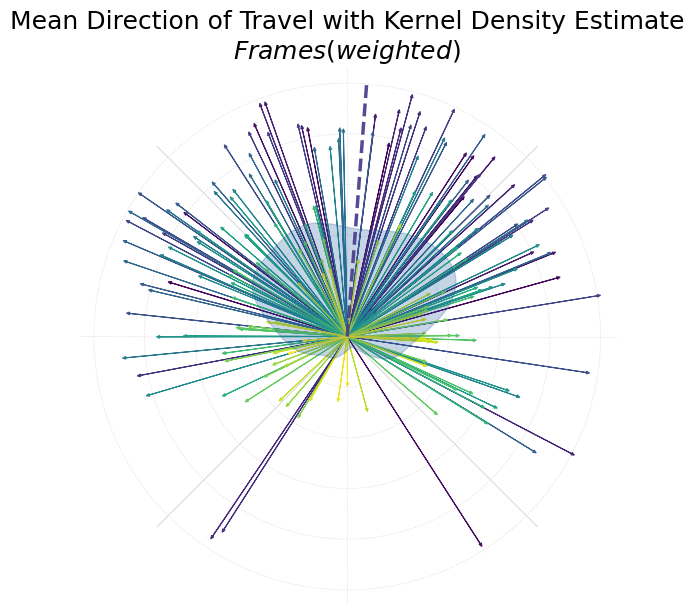

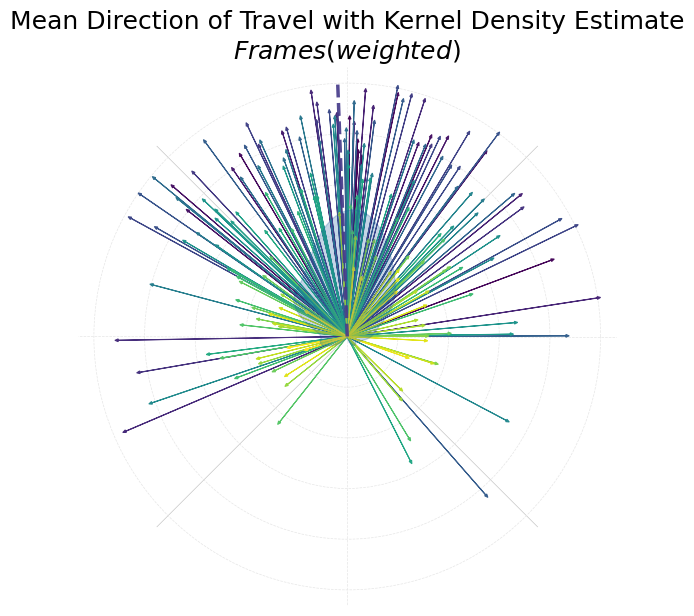

In [ ]:
cmap_cells = mcolors.LinearSegmentedColormap.from_list("", ["#9b598910", "#9b181eff"]) #303030
cmap_frames = plt.get_cmap('viridis')

def migration_directions_with_kde_plus_mean(df, metric, subject, scaling_metric, cmap_normalization_metric, cmap, threshold):

    # Recognizing the presence of a threshold
    if threshold == None:
        threshold = '_no_threshold'
    else:
        threshold = '_' + threshold

    df_mean_direction = df[metric]

    # Prepare for KDE plot
    x_kde = np.cos(df_mean_direction)
    y_kde = np.sin(df_mean_direction)
    kde = gaussian_kde([x_kde, y_kde])

    # Define the grid for evaluation
    theta_kde = np.linspace(0, 2 * np.pi, 360)
    x_grid = np.cos(theta_kde)
    y_grid = np.sin(theta_kde)

    # Evaluate the KDE on the grid and normalize
    z_kde = kde.evaluate([x_grid, y_grid])
    z_kde = z_kde / z_kde.max() * 0.5  # Normalize to fit within the radial limit

    # Calculate the mean direction
    mean_direction = np.arctan2(np.mean(y_kde), np.mean(x_kde))

    # Start plotting
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'polar': True})

    # Plot KDE
    ax.plot(theta_kde, z_kde, label='Circular KDE', color='None', zorder=5)
    ax.fill(theta_kde, z_kde, alpha=0.25, color='#1b5a9e', zorder=5)

    # Directional Arrows
    scaling_max = df[scaling_metric].max()

    # Normalization of the color map
    if cmap_normalization_metric == None:
        norm = mcolors.Normalize(vmin=0, vmax=1)
    else:
        normalization_min = df[cmap_normalization_metric].min()
        normalization_max = df[cmap_normalization_metric].max()
        norm = mcolors.Normalize(vmin=normalization_min, vmax=normalization_max)

    # Row itteration
    for _, row in df.iterrows():
        scaling_metrics = row[scaling_metric]
        mean_direction_rad = row[metric]
        arrow_length = scaling_metrics / scaling_max

        if cmap_normalization_metric == None:
            color = cmap(norm(arrow_length))
        else:
            color = cmap(norm(row[cmap_normalization_metric]))

        if arrow_length == 0:
            continue  # Skip if the arrow length is zero

        # Dynamically adjust the head size based on arrow_length
        scaling_factor = 1 / arrow_length if arrow_length != 0 else 1
        head_width = 0.011 * scaling_factor
        head_length = 0.013

        ax.arrow(mean_direction_rad, 0, 0, arrow_length, color=color, linewidth=0.75, 
                head_width=head_width, head_length=head_length, zorder=4)

    # Plot the dashed line in the mean direction
    ax.plot([mean_direction, mean_direction], [0, 1], linestyle='--', color='darkslateblue', alpha=0.93, linewidth=2.5, zorder=6)

    # Hide the polar plot frame (spines) but keep the grid visible
    ax.spines['polar'].set_visible(False)
    # Customize grid lines (if needed)
    ax.grid(True, 'major', color='#C6C6C6', linestyle='-', linewidth=0.5, zorder=0)

    # Access and customize the radial grid lines
    radial_lines = ax.get_xgridlines()
    for i, line in enumerate(radial_lines):
        if i % 2 == 0:  # Customize every other radial grid line
            line.set_linestyle('--')
            line.set_color('#E6E6E6')
            line.set_linewidth(0.5)

    radial_lines = ax.get_ygridlines()
    for i, line in enumerate(radial_lines):
        line.set_linestyle('--')
        line.set_color('#E6E6E6')
        line.set_linewidth(0.5)

    # Customize the appearance of the polar plot
    ax.set_title(f'Mean Direction of Travel with Kernel Density Estimate\n$\it{{{subject}}}$', fontsize=title_size)
    ax.set_yticklabels([])  # Remove radial labels
    ax.set_xticklabels([])  # Remove angular labels

    # Save the plot
    plt.savefig(op.join(save_path, f'02c_Plot_directions_of_travel_with_mean_and_kernel_density_estimate_{subject}_{scaling_metric}{threshold}.png'), dpi=500)
    # plt.show()
migration_directions_with_kde_plus_mean(Track_stats, 'MEAN_DIRECTION_RAD', 'Cells', 'CONFINEMENT_RATIO', None, cmap_cells, None)
migration_directions_with_kde_plus_mean(Track_stats, 'MEAN_DIRECTION_RAD', 'Cells', 'NET_DISTANCE', None, cmap_cells, None)
# migration_directions_with_kde_plus_mean(Track_stats, 'MEAN_DIRECTION_DEG_weight_confinement', 'Cells (weighted)', 'CONFINEMENT_RATIO', None, cmap_cells, None)
# migration_directions_with_kde_plus_mean(Track_stats, 'MEAN_DIRECTION_DEG_weight_confinement', 'Cells (weighted)', 'NET_DISTANCE', None, cmap_cells, None)
# migration_directions_with_kde_plus_mean(Track_stats, 'MEAN_DIRECTION_RAD_weight_net_dis', 'Cells (weighted)', 'CONFINEMENT_RATIO', None, cmap_cells, None)
# migration_directions_with_kde_plus_mean(Track_stats, 'MEAN_DIRECTION_DEG_weight_net_dis', 'Cells (weighted)', 'NET_DISTANCE', None, cmap_cells, None)
migration_directions_with_kde_plus_mean(Frame_stats, 'MEAN_DIRECTION_RAD', 'Frames (weighted)', 'MEAN_DISTANCE', 'POSITION_T', cmap_frames, None)
migration_directions_with_kde_plus_mean(Frame_stats, 'MEAN_DIRECTION_RAD_weight_mean_dis', 'Frames (weighted)', 'MEAN_DISTANCE', 'POSITION_T', cmap_frames, None) 

In [ ]:
def donut(df, ax, outer_radius, inner_radius, kde_bw):
    # Extend the data circularly to account for wrap-around at 0 and 2*pi
    extended_data = np.concatenate([df - 2 * np.pi, df, df + 2 * np.pi])

    # Create a grid of theta values (angles)
    theta_grid = np.linspace(0, 2 * np.pi, 360)  # 360 points over full circle
    
    # Create a grid of radii
    r_grid = np.linspace(inner_radius, outer_radius, 100)  # Radius from inner to outer edge
    
    # Compute KDE values for the extended data
    kde = gaussian_kde(extended_data, bw_method=kde_bw)
    kde_values = kde.evaluate(theta_grid)  # Evaluate KDE on the regular theta grid
    
    # Repeat KDE values across radii to create the heatmap data
    kde_values = np.tile(kde_values, (r_grid.size, 1))
    
    # Normalize KDE values for consistent color mapping
    norm = Normalize(vmin=kde_values.min(), vmax=kde_values.max())
    
    # Create the meshgrid for the polar plot
    theta_mesh, r_mesh = np.meshgrid(theta_grid, r_grid)
    
    # Remove polar grid lines and labels
    ax.grid(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.spines['polar'].set_visible(False)  # Hide the outer frame

    return theta_mesh, r_mesh, kde_values, norm

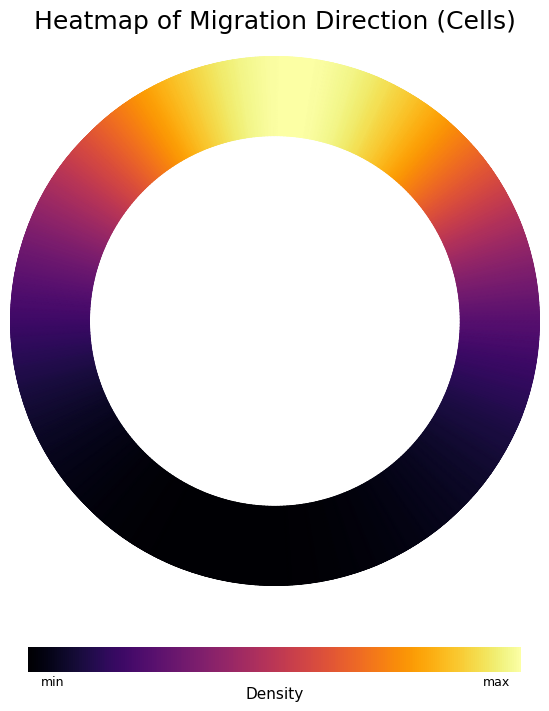

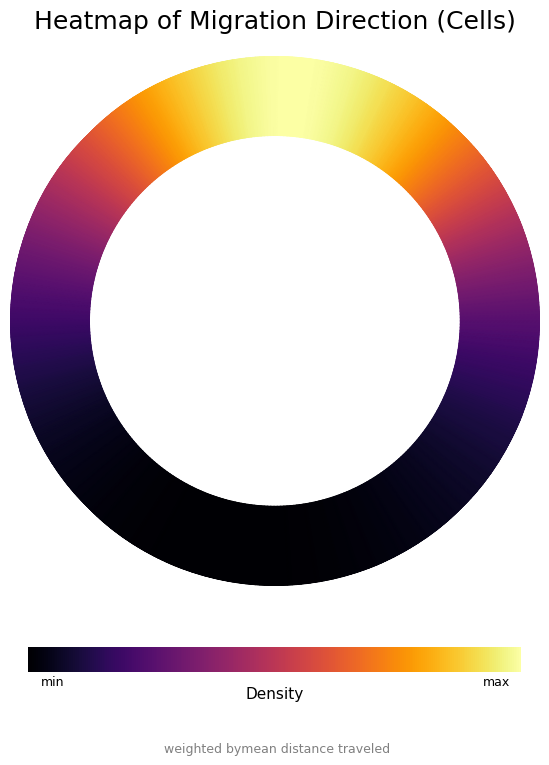

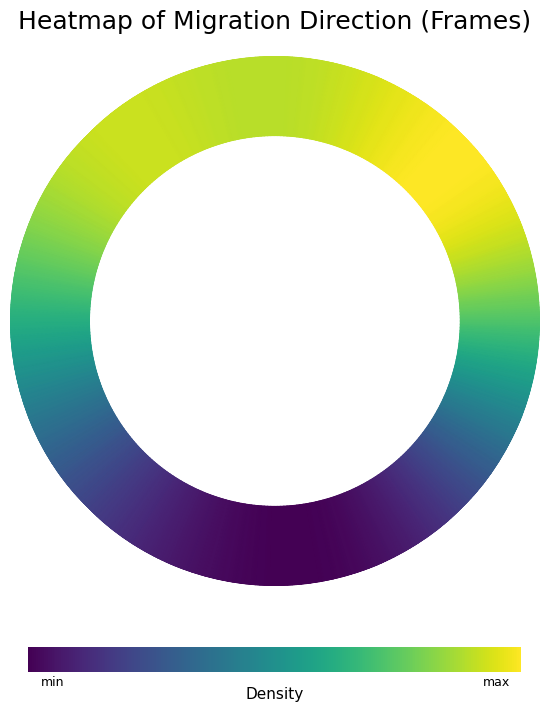

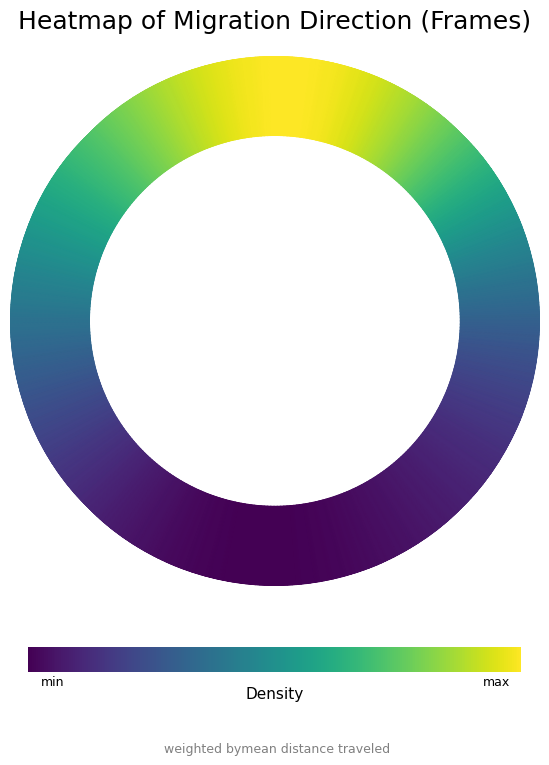

In [ ]:

def df_gaussian_donut(df, metric, subject, heatmap, weight, threshold):

    # Recognizing the presence of a threshold
    if threshold == None:
        threshold = '_no_threshold'
    else:
        threshold = '_' + threshold

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
    
    diameter=2
    width_ratio=0.3
    kde_bw=0.1

    df=df[metric]

    # Calculate radius and width from the diameter
    outer_radius = diameter / 2
    width = width_ratio * outer_radius
    inner_radius = outer_radius - width
    
    theta_mesh, r_mesh, kde_values, norm = donut(df, ax, outer_radius, inner_radius, kde_bw)
    
    # Set title and figure text
    ax.set_title(f'Heatmap of Migration Direction ({subject})', pad=20, ha='center', fontsize=title_size)
    
    # Add a colorbar
    cbar = plt.colorbar(ax.pcolormesh(theta_mesh, r_mesh, kde_values, shading='gouraud', cmap=heatmap, norm=norm), ax=ax, fraction=0.04, orientation='horizontal', pad=0.1)
    cbar.set_ticks([])
    cbar.outline.set_visible(False)  # Remove outline
    
    # Add min and max labels below the colorbar
    cbar.ax.text(0.05, -0.4, 'min', va='center', ha='center', color='black', transform=cbar.ax.transAxes, fontsize=9)
    cbar.ax.text(0.95, -0.4, 'max', va='center', ha='center', color='black', transform=cbar.ax.transAxes, fontsize=9)

    # Add the density label below the min and max labels
    cbar.set_label('Density', labelpad=10, fontsize=label_size)
    
    if weight == None:
        plt.savefig(op.join(save_path, f'04a_Plot_donut_heatmap-migration_direction_{subject}{threshold}.png'), dpi=300)
    else:
        weight = 'weighted by' + weight
        plt.figtext(0.515, 0.01, f'{weight}', ha='center', color=figtext_color, fontsize=figtext_size)
        plt.savefig(op.join(save_path, f'04a_Plot_donut_heatmap-migration_direction_{subject}{weight}{threshold}.png'), dpi=300)

    # plt.show()
df_gaussian_donut(Track_stats, 'MEAN_DIRECTION_RAD', 'Cells', 'inferno', None, None)
df_gaussian_donut(Track_stats, 'MEAN_DIRECTION_RAD', 'Cells', 'inferno', 'mean distance traveled', None)
# df_gaussian_donut(Track_stats_thresholded_at_20th_percentile, 'MEAN_DIRECTION_RAD', 'Cells', 'inferno', 'thresholded_at_20th_percentile') # 20th
# df_gaussian_donut(Track_stats_thresholded_at_40th_percentile, 'MEAN_DIRECTION_RAD', 'Cells', 'inferno', 'thresholded_at_40th_percentile') # 40th
# df_gaussian_donut(Track_stats_thresholded_at_60th_percentile, 'MEAN_DIRECTION_RAD', 'Cells', 'inferno', 'thresholded_at_60th_percentile') # 60th
# df_gaussian_donut(Track_stats_thresholded_at_80th_percentile, 'MEAN_DIRECTION_RAD', 'Cells', 'inferno', 'thresholded_at_80th_percentile') # 80th
# df_gaussian_donut(Track_stats_thresholded_at_90th_percentile, 'MEAN_DIRECTION_RAD', 'Cells', 'inferno', 'thresholded_at_90th_percentile') # 90th
df_gaussian_donut(Frame_stats, 'MEAN_DIRECTION_RAD', 'Frames', 'viridis', None, None)
df_gaussian_donut(Frame_stats, 'MEAN_DIRECTION_RAD_weight_mean_dis', 'Frames', 'viridis', 'mean distance traveled', None)


---
# *To try* / *To do* List

<ul>
    <li><input type="checkbox"> Weight Mean direction of travel in Time_Stats also by the NET_DISTANCE, making the dataset contain two columns for the weighted mean direction; by confinement ratio as well as net distance </li>

</ul>
